# Summary

The dataset I made starts off with the player stats being in their own dataframes. So the first thing I did was testing different ways of moving the player data into the main row. I tested with the average, deviation, difference of averages, and individual players. After testing the accuracy with different combinations of this data. I found that the average, deviation, and the difference for the match stats were the best combination.

I then tested the data with 3 different models: Decision Trees, AdaBoost of Decision Trees, and Random Forest. I tuned the hyperparameters for all three different models to find their accuracies. Because of the inherit randomness of who wins a valorant match my target was the the accuracy of the betting odds. The final results of my model are as follows:
- Accuracy from Odds: 0.6194444444444445
- Accuracy from DecisionTree: 0.5748888888888888
- Accuracy from AdaBoost: 0.6011111111111112
- Accuracy from RandomForest: 0.6213888888888889

The accuracy of the random forest model ended up matching the accuracy of the odds. I am also surprised at how accurate the decision tree is. From a tree of only length 8 it is able to prediction the result of matches consistently. I am also very happy with the results of the final accuracy. The odds makers have much more data to work with along with experts so I am very happy with the results of my model.

I also trained a Random Forest Regressor to predict the odds of a match. I am just predicting a form of the odds collected so I am really just predicting a prediction so there is no real way for my odds to be better. If I were to want to make I would have tochose a different method. The result of the testing wasn't as impressive as predicting the winner but I feel it still ended up doing well.

#### Odds Prediction result
Closer to green diagonal line the better. Color in correct half means it predicted the winner. Red is the trendline.
#### Raw output
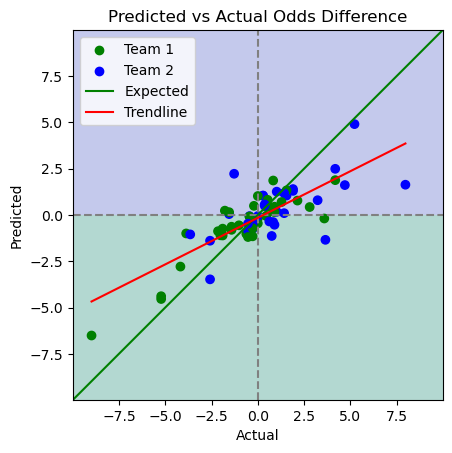
#### Adjusted output
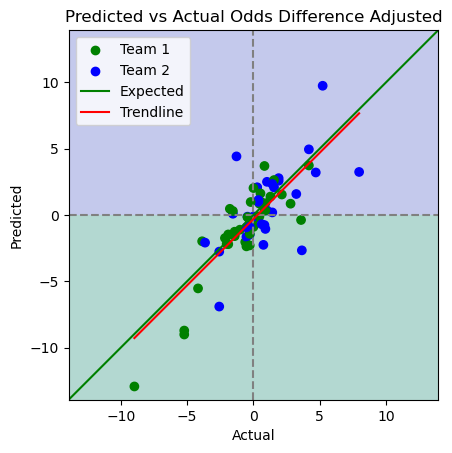

### Testing Hyper parameters to find trends:
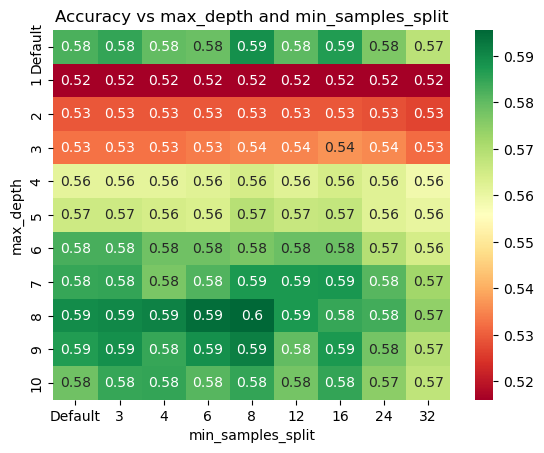

### Example tree:
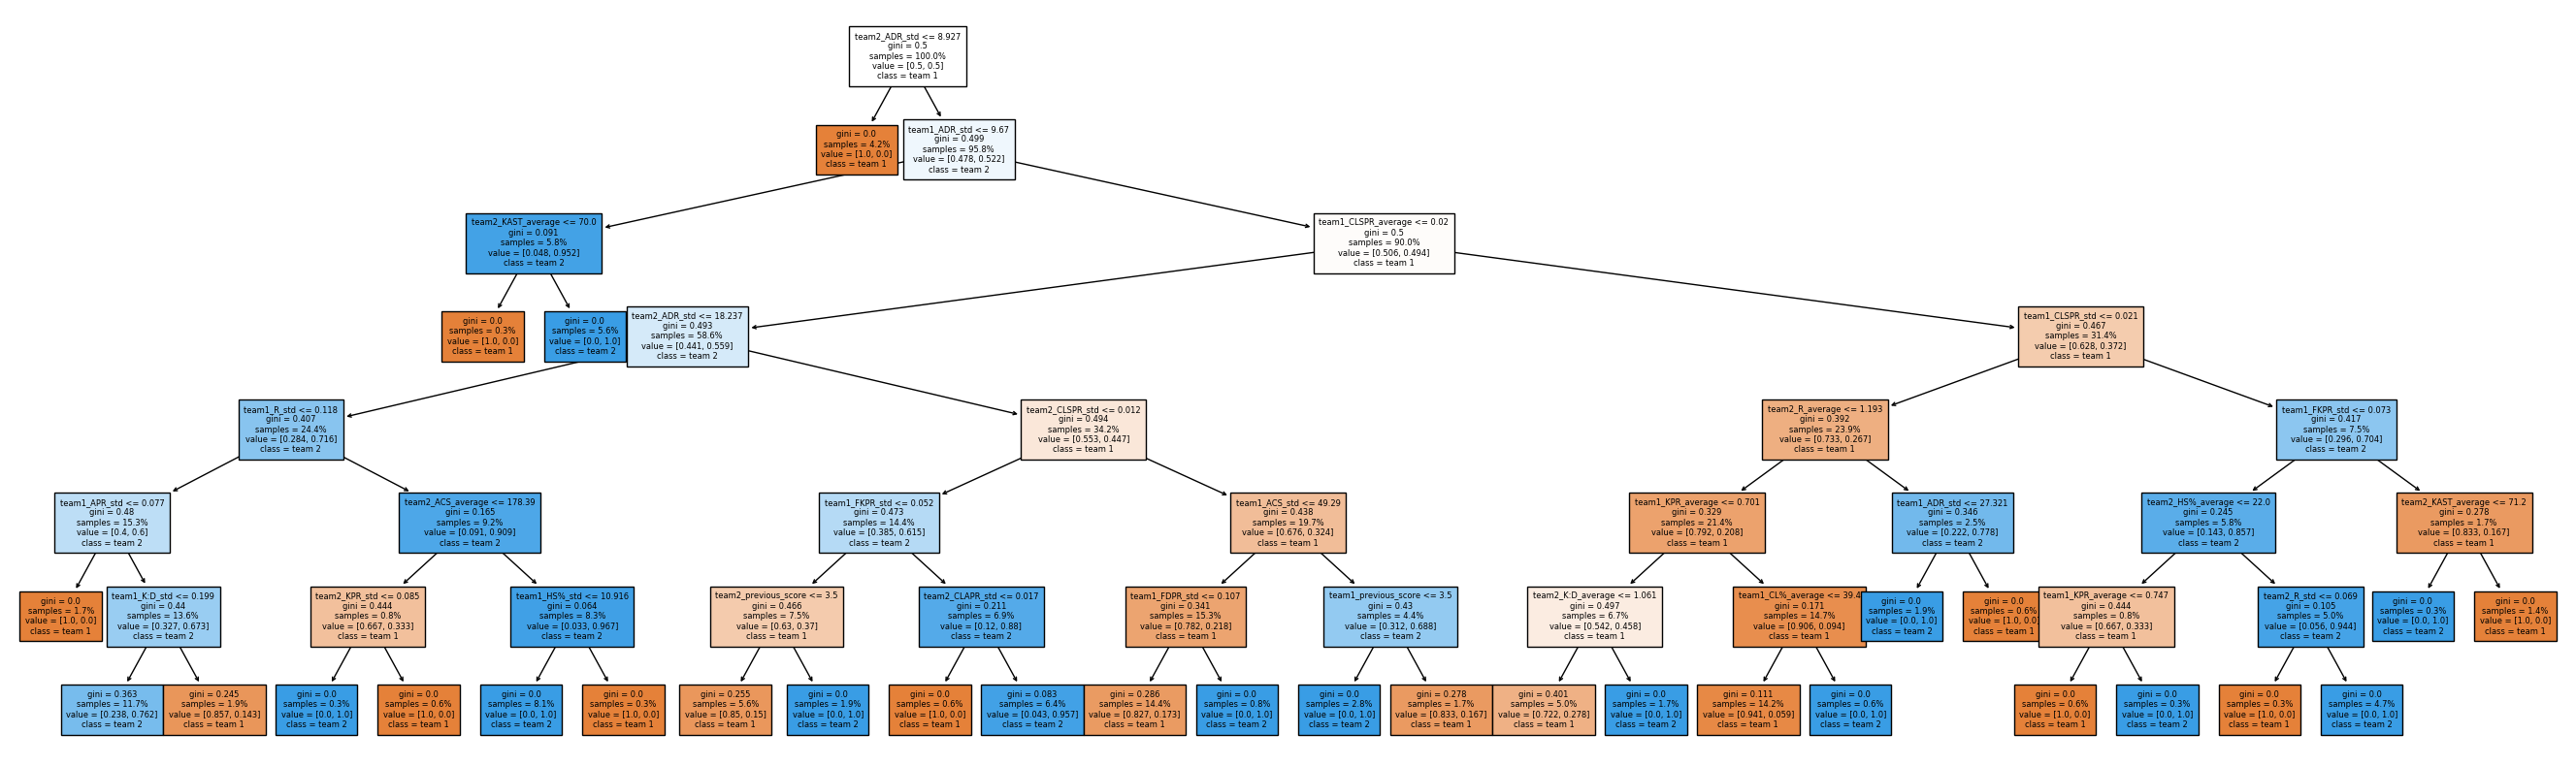

# Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import random
from io import StringIO

# Libraries for sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

# For slope of line for increasing slope of line
from scipy.stats import linregress

# For constraining the types of functions
from typing import Optional, List, Tuple, Union
from functools import partial
from enum import Enum

### Categorizing Columns in the input data

In [6]:
# For normalizing some stats by round
rounds_col = "Rnd"

# From total amount into per round
to_normalize = ["CL Success", "CL Attempts", "D"]
to_normalize_new_names = ["CLSPR", "CLAPR", "DPR"]

# All player statistics
to_keep = to_normalize_new_names + ["R", "ACS", "K:D", "KAST", "ADR", "KPR", "APR", "FKPR", "FDPR", "HS%", "CL%"]

# Filepath
default_filepath = "final_stats.csv"

# Events to exclude (player data incomplete)
excluded_matches = [1664, 1926]

In [7]:
# Enum for merge type (average or players)
class MergeType(Enum):
  AVERAGE = "average"
  PLAYERS = "players"
  DIFFERENCE = "difference"

## Loading Dataset Functions

#### Loads the dataset from the file
Player stats are stored as csv so it converts the csv to a pandas dataframe

In [8]:
# Loads the dataset from the file and converts the player stats columns into dataframes
def load_matches(filepath: str = default_filepath) -> pd.DataFrame:
  matches_df = pd.read_csv(filepath)
  
  # convert team1_stats and team2_stats from strings of dataframes to dataframes
  matches_df["team1_stats"] = matches_df["team1_stats"].apply(lambda x: pd.read_csv(StringIO(x)))
  matches_df["team2_stats"] = matches_df["team2_stats"].apply(lambda x: pd.read_csv(StringIO(x)))
  
  return matches_df

# load the matches from the file
matches_df = load_matches()
display(matches_df["team1_stats"][0])


,Player,Team,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,HS%,CL%,CL Success,CL Attempts,KMax,K,D,A,FK,FD
0,zekken,SEN,64,1.17,289.7,1.28,75.0,185.7,1.00,0.20,...,22.0,40.0,2.0,5.0,27,64,50,13,17,11
1,Zellsis,SEN,64,0.97,184.3,1.02,70.0,124.0,0.69,0.38,...,18.0,22.0,2.0,9.0,21,44,43,24,4,5
2,TenZ,SEN,64,0.96,194.3,0.98,73.0,123.1,0.77,0.44,...,25.0,NaN,0.0,5.0,21,49,50,28,6,5
3,johnqt,SEN,64,0.92,168.7,0.74,66.0,124.1,0.50,0.30,...,19.0,21.0,3.0,14.0,12,32,43,19,2,5
4,Sacy,SEN,64,0.91,171.0,0.73,69.0,113.7,0.55,0.42,...,28.0,14.0,1.0,7.0,17,35,48,27,1,8


For making a deep copy og dataframe

In [9]:
# Function to make deep copy of the dataset and it's children
def copy_matches_df(matches_df: pd.DataFrame) -> pd.DataFrame:
  new_df = matches_df.copy(deep=True)
  
  # copy all of the dataframes in team1_stats and team2_stats
  new_df["team1_stats"] = new_df["team1_stats"].apply(lambda x: x.copy(deep=True))
  new_df["team2_stats"] = new_df["team2_stats"].apply(lambda x: x.copy(deep=True))
  
  return new_df

For merging all player stats into one dataframe for testing

In [10]:
# Merges all the player stats into one dataset
def get_player_stats(df: pd.DataFrame) -> pd.DataFrame:
  # merge all of the dataframes in team1_stats one dataframe
  # type(df["team1_stats"]) == pd.Series of pd.DataFrames
  team1_stats = pd.concat(df["team1_stats"].tolist(), ignore_index=True)
  team2_stats = pd.concat(df["team2_stats"].tolist(), ignore_index=True)
  player_stats = pd.concat([team1_stats, team2_stats], ignore_index=True)
  return player_stats

players = get_player_stats(matches_df)
display(players)

,Player,Team,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,HS%,CL%,CL Success,CL Attempts,KMax,K,D,A,FK,FD
0,zekken,SEN,64,1.17,289.7,1.28,75.0,185.7,1.00,0.20,...,22.0,40.0,2.0,5.0,27,64,50,13,17,11
1,Zellsis,SEN,64,0.97,184.3,1.02,70.0,124.0,0.69,0.38,...,18.0,22.0,2.0,9.0,21,44,43,24,4,5
2,TenZ,SEN,64,0.96,194.3,0.98,73.0,123.1,0.77,0.44,...,25.0,NaN,0.0,5.0,21,49,50,28,6,5
3,johnqt,SEN,64,0.92,168.7,0.74,66.0,124.1,0.50,0.30,...,19.0,21.0,3.0,14.0,12,32,43,19,2,5
4,Sacy,SEN,64,0.91,171.0,0.73,69.0,113.7,0.55,0.42,...,28.0,14.0,1.0,7.0,17,35,48,27,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,Bizerra,TL,244,1.14,211.8,1.18,71.0,140.3,0.75,0.34,...,26.0,22.0,7.0,32.0,26,184,156,83,31,18
3913,daiki,TL,244,1.13,217.6,1.07,79.0,135.3,0.75,0.45,...,25.0,15.0,4.0,26.0,24,182,170,111,21,11
3914,bstrdd,TL,244,1.06,234.0,1.15,70.0,155.1,0.84,0.14,...,30.0,14.0,2.0,14.0,26,206,179,35,41,44
3915,Joojina,TL,244,1.03,201.5,1.02,73.0,134.3,0.72,0.37,...,29.0,27.0,7.0,26.0,23,176,172,91,18,21


In [11]:
# Info on overall player stats
display(players.describe())
# shows missing values (doesnt display 0s)
display(players.isnull().sum()[players.isnull().sum() > 0])

,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL Success,CL Attempts,KMax,K,D,A,FK,FD
count,3917.000000,3847.000000,3917.000000,3917.000000,3847.000000,3847.000000,3917.000000,3917.000000,3847.000000,3847.000000,3847.000000,3138.000000,3814.000000,3814.000000,3917.000000,3917.000000,3917.000000,3917.000000,3917.000000,3917.000000
mean,179.038295,1.031159,201.301966,1.047582,72.774890,131.793865,0.705443,0.313201,0.101770,0.098102,25.988043,19.920969,3.114578,19.476927,21.708195,126.476385,122.273168,56.379117,17.949196,17.242277
std,135.650527,0.161549,33.922230,0.258468,6.088852,21.292416,0.127549,0.123510,0.056719,0.048670,5.677717,12.375519,3.034331,16.027526,5.204634,98.277498,92.414814,49.152662,17.987716,15.861352
min,15.000000,0.150000,66.000000,0.190000,30.000000,45.100000,0.190000,0.000000,0.000000,0.000000,10.000000,3.000000,0.000000,1.000000,4.000000,6.000000,4.000000,0.000000,0.000000,0.000000
25%,76.000000,0.930000,179.800000,0.890000,69.500000,118.400000,0.630000,0.210000,0.060000,0.060000,22.000000,12.000000,1.000000,8.000000,18.000000,52.000000,51.000000,21.000000,6.000000,6.000000
50%,138.000000,1.030000,199.100000,1.030000,73.000000,130.400000,0.700000,0.310000,0.090000,0.090000,25.000000,17.000000,2.000000,14.000000,22.000000,98.000000,95.000000,41.000000,12.000000,12.000000
75%,251.000000,1.120000,219.500000,1.160000,76.000000,143.700000,0.770000,0.400000,0.130000,0.120000,29.000000,25.000000,4.000000,27.000000,25.000000,176.000000,170.000000,75.000000,24.000000,24.000000
max,702.000000,1.920000,434.500000,3.670000,100.000000,267.200000,1.610000,0.900000,0.550000,0.340000,60.000000,100.000000,20.000000,106.000000,42.000000,576.000000,484.000000,317.000000,138.000000,102.000000


R               70
KAST            70
ADR             70
FKPR            70
FDPR            70
HS%             70
CL%            779
CL Success     103
CL Attempts    103
dtype: int64

#### Cleaning the dataset

Removes events in the excluded matches list and changes the type of columns.
It also fills in NA values it can interpolate (mostly clutch related if player hasn't been in or won a 1vX).

In [12]:
# Cleans the dataset
def clean_stats(matches_df: pd.DataFrame) -> pd.DataFrame:
  new_df = copy_matches_df(matches_df)
  
  if "event_code" not in new_df.columns:
    #add event_code column
    new_df["event_code"] = 0
    new_df["t1 odds"] = 0
    new_df["t2 odds"] = 0
    
  # remove matches with an event_code in the list excluded_matches
  new_df = new_df[~new_df["event_code"].isin(excluded_matches)]
  
  # remove matches with nan odds
  new_df = new_df.dropna(subset=["t1 odds", "t2 odds"])
  
  # set type of odds to float
  new_df["t1 odds"] = new_df["t1 odds"].astype(float)
  new_df["t2 odds"] = new_df["t2 odds"].astype(float)
  
  # set the type of the winner column to int
  new_df["winner"] = new_df["winner"].astype(int)
  
  # setting hth and previous winner to float
  new_df["team1_hth"] = new_df["team1_hth"].astype(float)
  new_df["team2_hth"] = new_df["team2_hth"].astype(float)
  new_df["team1_previous_score"] = new_df["team1_previous_score"].astype(int)
  new_df["team2_previous_score"] = new_df["team2_previous_score"].astype(int)
  
  # If any team_stats have more than 5 players drop the row
  new_df = new_df[new_df["team1_stats"].apply(len) == 5]
  new_df = new_df[new_df["team2_stats"].apply(len) == 5]
  
  
  
  # Fills nans in clutch data
  def fill_nan_clutches(stats: pd.Series) -> pd.Series:
    for df in stats:
      for index, row in df.iterrows():
        # If no attempt set all to 0
        if np.isnan(row["CL Attempts"]):
          df.at[index, "CL Attempts"] = 0
          df.at[index, "CL Success"] = 0
          df.at[index, "CL%"] = 0
        
        # If just CL% is 0 then set cl% to 0
        if np.isnan(row["CL%"]):
          df.at[index, "CL%"] = 0
  
  fill_nan_clutches(new_df["team1_stats"])
  fill_nan_clutches(new_df["team2_stats"])
  return new_df
  
players = get_player_stats(matches_df)
display(players.isnull().sum().sum())

matches_clean = clean_stats(matches_df)
  
players = get_player_stats(matches_clean)
display(players.isnull().sum().sum())

1405

0

#### Normalizing stats by rounds

Turning certain stats that are totaled like clutch count into per round (Deaths into Deaths per round)

In [13]:
# normalizes certain stats to be based on the amount of rounds played, removes non-normalized stats
def normalize_player_stats(players: pd.DataFrame):
  for i in range(len(to_normalize)):
    players[to_normalize_new_names[i]] = players[to_normalize[i]] / players[rounds_col]
  
  # Drop all columns that are not in to_keep
  players.drop(columns=[col for col in players.columns if col not in to_keep], inplace=True)
  
# Get all players
players = get_player_stats(matches_clean)
display(players.head(1))
# Normalize the stats
normalize_player_stats(players)
display(players.head(1))

# Applies the normalization to all matches
def normalize_match_stats(matches_df: pd.DataFrame) -> pd.DataFrame:
  new_df = copy_matches_df(matches_df)
  
  new_df["team1_stats"].apply(lambda x: normalize_player_stats(x))
  new_df["team2_stats"].apply(lambda x: normalize_player_stats(x))
  
  return new_df

# Test the normalization
matches_normalized = normalize_match_stats(matches_clean)
display(matches_normalized["team1_stats"][0].head(1))

,Player,Team,Rnd,R,ACS,K:D,KAST,ADR,KPR,APR,...,HS%,CL%,CL Success,CL Attempts,KMax,K,D,A,FK,FD
0,zekken,SEN,64,1.17,289.7,1.28,75.0,185.7,1.0,0.2,...,22.0,40.0,2.0,5.0,27,64,50,13,17,11


,R,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CLSPR,CLAPR,DPR
0,1.17,289.7,1.28,75.0,185.7,1.0,0.2,0.27,0.17,22.0,40.0,0.03125,0.078125,0.78125


,R,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CLSPR,CLAPR,DPR
0,1.17,289.7,1.28,75.0,185.7,1.0,0.2,0.27,0.17,22.0,40.0,0.03125,0.078125,0.78125


#### Mirrors all matches 
So it isn't favored by the order teams are put in

In [14]:
# For every match, create a new row with the team1 stats and team2 stats swapped
def mirror_matches(matches_averaged: pd.DataFrame) -> pd.DataFrame:
  new_df = matches_averaged.copy(deep=True)
  for index, row in new_df.iterrows():
    new_row = row.copy(deep=True)
    new_row.index = [col.replace("team1_", "team2_") if "team1_" in col else col.replace("team2_", "team1_") for col in new_row.index]
    # flip winner
    if new_row["winner"] == 1:
      new_row["winner"] = 2
    elif new_row["winner"] == 2:
      new_row["winner"] = 1
      
    new_row["t1 odds"], new_row["t2 odds"] = new_row["t2 odds"], new_row["t1 odds"]
    
    new_row["team1"], new_row["team2"] = new_row["team2"], new_row["team1"]
    
    new_df = pd.concat([new_df, new_row.to_frame().T], ignore_index=True)
  
  # set the type of the winner column to int
  new_df["winner"] = new_df["winner"].astype(int)
  
  return new_df

# Test the mirroring
matches_mirrored = mirror_matches(matches_normalized)

#### Merging player stats

I have 3 different ways of merging the player stats
1. By adding all stats in as "team_n_stat_player_n"
2. By getting the average of each team's stats as "team_n_stat_average" and deviation "team_n_stat_std"
3. By getting the difference of the average between the two teams "stat_diff"

In [15]:
# Combines players into an average and deviation
def merge_team_stats_average(new_df: pd.DataFrame, row: pd.Series, index: int, player_stats_columns: List[str]):
  team1_stats = row["team1_stats"]
  team2_stats = row["team2_stats"]
  
  # average
  for col in player_stats_columns:
    new_df.at[index, "team1_" + col + "_average"] = team1_stats[col].mean()
    new_df.at[index, "team2_" + col + "_average"] = team2_stats[col].mean()
    
  # deviation
  for col in player_stats_columns:
    new_df.at[index, "team1_" + col + "_std"] = team1_stats[col].std()
    new_df.at[index, "team2_" + col + "_std"] = team2_stats[col].std()

# Seperates into "team_x_player_x" columns
def merge_team_stats_players(new_df: pd.DataFrame, row: pd.Series, index: int, player_stats_columns: List[str]):
  team1_stats = row["team1_stats"]
  team2_stats = row["team2_stats"]
  
  for i in range(len(team1_stats)):
    for col in player_stats_columns:
      new_df.at[index, "team1_" + col + "_player_" + str(i)] = team1_stats[col][i]
      new_df.at[index, "team2_" + col + "_player_" + str(i)] = team2_stats[col][i]
      
# Does subtracts the average of team1 from team2
def merge_team_stats_difference(new_df: pd.DataFrame, row: pd.Series, index: int, player_stats_columns: List[str]):
  team1_stats = row["team1_stats"]
  team2_stats = row["team2_stats"]
  for col in player_stats_columns:
    new_df.at[index, col + "_diff"] = team1_stats[col].mean() - team2_stats[col].mean()
    
  # merge teamx_previous_score and teamx_hth into previous_score_diff and hth_diff
  new_df.at[index, "previous_score_diff"] = row["team1_previous_score"] - row["team2_previous_score"]
  new_df.at[index, "hth_diff"] = row["team1_hth"] - row["team2_hth"]
  
  
# Merges the team stats into the row
def merge_team_stats(merge_type: MergeType, new_df: pd.DataFrame):
  if (merge_type == MergeType.AVERAGE):
    # Get the average of all stats from team1_stats and team2_stats
    # add them to the row as team1_{stat_name}
    
    # add the columns to the dataframe
    player_stats_columns = new_df["team1_stats"][0].columns
    for col in player_stats_columns:
      new_df["team1_" + col + "_average"] = 0
      new_df["team1_" + col + "_std"] = 0
    for col in player_stats_columns:
      new_df["team2_" + col + "_average"] = 0
      new_df["team2_" + col + "_std"] = 0
    
    for index, row in new_df.iterrows():
      merge_team_stats_average(new_df, row, index, player_stats_columns)
      
  elif (merge_type == MergeType.PLAYERS):
    # Get the stats of each player from team1_stats and team2_stats
    # add them to the row as team1_{stat_name}_player_{i}
    
    # add the columns to the dataframe
    player_stats_columns = new_df["team1_stats"][0].columns
    for col in player_stats_columns:
      for i in range(len(new_df["team1_stats"][0])):
        new_df["team1_" + col + "_player_" + str(i)] = 0
        new_df["team2_" + col + "_player_" + str(i)] = 0
      # unfragment
      new_df = new_df.copy(deep=True)
    
    for index, row in new_df.iterrows():
      merge_team_stats_players(new_df, row, index, player_stats_columns)
  
  elif (merge_type == MergeType.DIFFERENCE):
    # Get the difference between the average of team1_stats and team2_stats
    # add them to the row as {stat_name}_diff
    
    # add the columns to the dataframe
    player_stats_columns = new_df["team1_stats"][0].columns
    for col in player_stats_columns:
      new_df[col + "_diff"] = 0
    
    new_df["previous_score_diff"] = 0
    new_df["hth_diff"] = 0
    
      
    for index, row in new_df.iterrows():
      merge_team_stats_difference(new_df, row, index, list(player_stats_columns))
    
    # drop previous scores
    new_df.drop(columns=["team1_previous_score", "team2_previous_score", "team1_hth", "team2_hth"], inplace=True)
    
    
    # replace t1 odds and t2 odds with the difference
    new_df["odds_diff"] = new_df["t1 odds"] - new_df["t2 odds"]
    new_df.drop(columns=["t1 odds", "t2 odds"], inplace=True)
    new_df["odds_diff"]  = new_df["odds_diff"].astype(float)

  
  return new_df

def merge_stats(match_stats: pd.DataFrame, merge_type: MergeType, keep_teams: bool = False) -> pd.DataFrame:
  new_df = copy_matches_df(match_stats)
  
  new_df = merge_team_stats(merge_type, new_df)
  
  # drop the team1_stats and team2_stats columns
  new_df.drop(columns=["team1_stats", "team2_stats"], inplace=True)
  
  # removes non data columns
  if keep_teams:
    new_df.drop(columns=["series", "code", "event_code", "team1_abrev", "team2_abrev",], inplace=True)
  else:
    new_df.drop(columns=["date", "team1", "team2", "series", "code", "event_code", "team1_abrev", "team2_abrev",], inplace=True)
  
  # if any nan values exist print an error
  if new_df.isnull().sum().sum() > 0:
    print("ERROR: nan values exist in the dataframe")
  
  # drop all columns with nan values
  new_df.dropna(axis=1, inplace=True)
  
  return new_df

# Test pulling the difference
matches_data_tmp = merge_stats(matches_normalized, MergeType.DIFFERENCE)
display(matches_data_tmp.head(5))

,winner,R_diff,ACS_diff,K:D_diff,KAST_diff,ADR_diff,KPR_diff,APR_diff,FKPR_diff,FDPR_diff,HS%_diff,CL%_diff,CLSPR_diff,CLAPR_diff,DPR_diff,previous_score_diff,hth_diff,odds_diff
0,1,-0.118,-14.90,-0.204,-2.8,-13.76,-0.072,0.074,0.016,-0.012,-9.6,-1.4,0.002273,0.020455,0.053977,-1,0.0,0.00
1,2,0.078,12.04,0.092,7.2,11.10,0.054,0.056,0.016,-0.016,2.8,8.6,0.002491,0.005812,-0.024957,-1,0.0,0.90
2,2,-0.096,-1.38,-0.192,-3.6,-1.38,-0.034,-0.026,0.030,-0.034,3.2,7.8,0.015007,0.031602,0.096537,0,0.0,3.87
3,2,0.116,9.00,0.090,8.2,2.84,0.044,0.112,0.030,-0.032,-4.2,-8.8,-0.012115,-0.019856,-0.029231,1,0.0,0.06
4,1,0.084,8.14,0.194,1.2,3.24,0.038,0.002,-0.010,0.016,-2.0,-13.2,-0.014077,-0.030244,-0.070801,-1,-0.7,-0.37


# Function to load dataset

In [16]:
# Loads a dataset with the given merge type and path
def get_dataset(merge_type: MergeType = MergeType.AVERAGE, filepath: str = default_filepath, keep_teams: bool = False, mirror_set: bool = True) -> pd.DataFrame:
  matches_df = load_matches(filepath)
  matches_clean = clean_stats(matches_df)
  matches_normalized = normalize_match_stats(matches_clean)
  # Mirror if flag is set
  if mirror_set:
    matches_mirrored = mirror_matches(matches_normalized)
    return merge_stats(matches_mirrored, merge_type, keep_teams)
  else:
    return merge_stats(matches_normalized, merge_type, keep_teams)
  

# Pull the difference dataset
matches_difference = get_dataset(MergeType.DIFFERENCE)
display(matches_difference.head(5))

# Print first 5 matches of second half
size = len(matches_difference) // 2
display(matches_difference.iloc[size:size+5])

# Getting the features list
difference_features = [col for col in matches_difference.columns if col != "winner" and col != "odds_diff"]

,winner,R_diff,ACS_diff,K:D_diff,KAST_diff,ADR_diff,KPR_diff,APR_diff,FKPR_diff,FDPR_diff,HS%_diff,CL%_diff,CLSPR_diff,CLAPR_diff,DPR_diff,previous_score_diff,hth_diff,odds_diff
0,1,-0.118,-14.90,-0.204,-2.8,-13.76,-0.072,0.074,0.016,-0.012,-9.6,-1.4,0.002273,0.020455,0.053977,-1,0.0,0.00
1,2,0.078,12.04,0.092,7.2,11.10,0.054,0.056,0.016,-0.016,2.8,8.6,0.002491,0.005812,-0.024957,-1,0.0,0.90
2,2,-0.096,-1.38,-0.192,-3.6,-1.38,-0.034,-0.026,0.030,-0.034,3.2,7.8,0.015007,0.031602,0.096537,0,0.0,3.87
3,2,0.116,9.00,0.090,8.2,2.84,0.044,0.112,0.030,-0.032,-4.2,-8.8,-0.012115,-0.019856,-0.029231,1,0.0,0.06
4,1,0.084,8.14,0.194,1.2,3.24,0.038,0.002,-0.010,0.016,-2.0,-13.2,-0.014077,-0.030244,-0.070801,-1,-0.7,-0.37


,winner,R_diff,ACS_diff,K:D_diff,KAST_diff,ADR_diff,KPR_diff,APR_diff,FKPR_diff,FDPR_diff,HS%_diff,CL%_diff,CLSPR_diff,CLAPR_diff,DPR_diff,previous_score_diff,hth_diff,odds_diff
180,2,0.118,14.90,0.204,2.8,13.76,0.072,-0.074,-0.016,0.012,9.6,1.4,-0.002273,-0.020455,-0.053977,1,0.0,0.00
181,1,-0.078,-12.04,-0.092,-7.2,-11.10,-0.054,-0.056,-0.016,0.016,-2.8,-8.6,-0.002491,-0.005812,0.024957,1,0.0,-0.90
182,1,0.096,1.38,0.192,3.6,1.38,0.034,0.026,-0.030,0.034,-3.2,-7.8,-0.015007,-0.031602,-0.096537,0,0.0,-3.87
183,1,-0.116,-9.00,-0.090,-8.2,-2.84,-0.044,-0.112,-0.030,0.032,4.2,8.8,0.012115,0.019856,0.029231,-1,0.0,-0.06
184,2,-0.084,-8.14,-0.194,-1.2,-3.24,-0.038,-0.002,0.010,-0.016,2.0,13.2,0.014077,0.030244,0.070801,1,0.7,0.37


## Getting Average and Players merges

In [17]:
# Pull the average dataset and get it's features
matches_average = get_dataset(MergeType.AVERAGE)
display(matches_average.head(5))
average_features = [col for col in matches_average.columns if col != "winner" and col != "t1 odds" and col != "t2 odds"]
print(average_features)

# Pull the players dataset and get it's features
matches_players = get_dataset(MergeType.PLAYERS)
display(matches_players.head(5))
players_features = [col for col in matches_players.columns if col != "winner" and col != "t1 odds" and col != "t2 odds"]
print(players_features)

,winner,t1 odds,t2 odds,team1_previous_score,team2_previous_score,team1_hth,team2_hth,team1_R_average,team1_R_std,team1_ACS_average,...,team2_HS%_average,team2_HS%_std,team2_CL%_average,team2_CL%_std,team2_CLSPR_average,team2_CLSPR_std,team2_CLAPR_average,team2_CLAPR_std,team2_DPR_average,team2_DPR_std
0,1,1.85,1.85,4,5,0.0,0.0,0.986,0.105972,201.60,...,32.0,10.222524,20.8,32.797866,0.022727,0.032141,0.104545,0.076399,0.677273,0.040656
1,2,2.4,1.5,4,5,0.0,0.0,1.080,0.038079,204.86,...,25.8,3.563706,11.8,13.809417,0.019048,0.026082,0.111111,0.068272,0.711111,0.058752
2,2,5.0,1.13,3,3,0.0,0.0,0.902,0.171959,197.00,...,27.8,8.348653,3.4,7.602631,0.003175,0.007099,0.104762,0.058966,0.676190,0.079840
3,2,1.88,1.82,3,2,0.0,0.0,1.040,0.180693,205.38,...,30.6,7.368853,19.4,14.258331,0.024615,0.017541,0.129231,0.031902,0.729231,0.042967
4,1,1.68,2.05,3,4,4.966667,5.666667,1.076,0.187563,207.24,...,28.4,2.880972,19.4,16.272676,0.017886,0.012059,0.123577,0.067631,0.720325,0.035717


['team1_previous_score', 'team2_previous_score', 'team1_hth', 'team2_hth', 'team1_R_average', 'team1_R_std', 'team1_ACS_average', 'team1_ACS_std', 'team1_K:D_average', 'team1_K:D_std', 'team1_KAST_average', 'team1_KAST_std', 'team1_ADR_average', 'team1_ADR_std', 'team1_KPR_average', 'team1_KPR_std', 'team1_APR_average', 'team1_APR_std', 'team1_FKPR_average', 'team1_FKPR_std', 'team1_FDPR_average', 'team1_FDPR_std', 'team1_HS%_average', 'team1_HS%_std', 'team1_CL%_average', 'team1_CL%_std', 'team1_CLSPR_average', 'team1_CLSPR_std', 'team1_CLAPR_average', 'team1_CLAPR_std', 'team1_DPR_average', 'team1_DPR_std', 'team2_R_average', 'team2_R_std', 'team2_ACS_average', 'team2_ACS_std', 'team2_K:D_average', 'team2_K:D_std', 'team2_KAST_average', 'team2_KAST_std', 'team2_ADR_average', 'team2_ADR_std', 'team2_KPR_average', 'team2_KPR_std', 'team2_APR_average', 'team2_APR_std', 'team2_FKPR_average', 'team2_FKPR_std', 'team2_FDPR_average', 'team2_FDPR_std', 'team2_HS%_average', 'team2_HS%_std', '

,winner,t1 odds,t2 odds,team1_previous_score,team2_previous_score,team1_hth,team2_hth,team1_R_player_0,team2_R_player_0,team1_R_player_1,...,team1_DPR_player_0,team2_DPR_player_0,team1_DPR_player_1,team2_DPR_player_1,team1_DPR_player_2,team2_DPR_player_2,team1_DPR_player_3,team2_DPR_player_3,team1_DPR_player_4,team2_DPR_player_4
0,1,1.85,1.85,4,5,0.0,0.0,1.17,1.53,0.97,...,0.781250,0.636364,0.671875,0.636364,0.781250,0.704545,0.671875,0.727273,0.750000,0.681818
1,2,2.4,1.5,4,5,0.0,0.0,1.13,1.21,1.10,...,0.676923,0.634921,0.630769,0.698413,0.692308,0.682540,0.784615,0.777778,0.646154,0.761905
2,2,5.0,1.13,3,3,0.0,0.0,1.17,1.26,0.93,...,0.704545,0.603175,0.795455,0.587302,0.863636,0.682540,0.772727,0.761905,0.727273,0.746032
3,2,1.88,1.82,3,2,0.0,0.0,1.23,1.15,1.21,...,0.718750,0.707692,0.687500,0.692308,0.671875,0.738462,0.703125,0.707692,0.718750,0.800000
4,1,1.68,2.05,3,4,4.966667,5.666667,1.31,1.16,1.19,...,0.571429,0.780488,0.571429,0.707317,0.638095,0.691057,0.704762,0.699187,0.761905,0.723577


['team1_previous_score', 'team2_previous_score', 'team1_hth', 'team2_hth', 'team1_R_player_0', 'team2_R_player_0', 'team1_R_player_1', 'team2_R_player_1', 'team1_R_player_2', 'team2_R_player_2', 'team1_R_player_3', 'team2_R_player_3', 'team1_R_player_4', 'team2_R_player_4', 'team1_ACS_player_0', 'team2_ACS_player_0', 'team1_ACS_player_1', 'team2_ACS_player_1', 'team1_ACS_player_2', 'team2_ACS_player_2', 'team1_ACS_player_3', 'team2_ACS_player_3', 'team1_ACS_player_4', 'team2_ACS_player_4', 'team1_K:D_player_0', 'team2_K:D_player_0', 'team1_K:D_player_1', 'team2_K:D_player_1', 'team1_K:D_player_2', 'team2_K:D_player_2', 'team1_K:D_player_3', 'team2_K:D_player_3', 'team1_K:D_player_4', 'team2_K:D_player_4', 'team1_KAST_player_0', 'team2_KAST_player_0', 'team1_KAST_player_1', 'team2_KAST_player_1', 'team1_KAST_player_2', 'team2_KAST_player_2', 'team1_KAST_player_3', 'team2_KAST_player_3', 'team1_KAST_player_4', 'team2_KAST_player_4', 'team1_ADR_player_0', 'team2_ADR_player_0', 'team1_ADR_

## Correlations

In [18]:
# print the columns with the most correlation to the winner
def get_winner_correlation(df: pd.DataFrame, n: int, use_abs: bool):
  # sort by the absolute value of the correlation
  if use_abs:
    corr = df.corr()["winner"].sort_values(key=lambda x: np.abs(x), ascending=False)
  else:
    corr = df.corr()["winner"].sort_values(ascending=False)
  display(corr.head(n))

# Get the correlation of the average and difference datasets
get_winner_correlation(matches_average, 20, False)
get_winner_correlation(matches_difference, 20, True)

winner                 1.000000
team1_FDPR_std         0.096609
team2_FKPR_average     0.093508
team1_FDPR_average     0.087730
team1_CL%_std          0.086853
team2_KAST_average     0.075478
team2_CLSPR_average    0.074255
team1_DPR_average      0.073740
team1_CLAPR_std        0.069071
team2_K:D_average      0.066808
team1_HS%_average      0.066241
team2_R_average        0.065839
team2_APR_average      0.061485
team1_FKPR_std         0.057944
team2_CL%_average      0.051726
team2_ACS_average      0.049420
team1_DPR_std          0.046611
team2_ADR_average      0.046559
team2_KPR_average      0.040668
team2_HS%_std          0.039114
Name: winner, dtype: float64

winner                 1.000000
odds_diff              0.339555
previous_score_diff   -0.214857
FKPR_diff             -0.139040
FDPR_diff              0.131212
KAST_diff             -0.123265
DPR_diff               0.116870
R_diff                -0.110165
CLSPR_diff            -0.104403
K:D_diff              -0.103753
HS%_diff               0.102168
hth_diff              -0.101691
APR_diff              -0.094583
ACS_diff              -0.078885
CL%_diff              -0.075293
ADR_diff              -0.069784
KPR_diff              -0.063652
CLAPR_diff             0.033010
Name: winner, dtype: float64

Surprisingly the most correlated statistic to the winner for the average stat is the First Deaths Per Round deviation. The highest the correlation is just under 0.1. When comparing the stats with the highest correlation to what stats are most important in the game it seems to line up very well.

For the Difference graph it was much of the same but the correlations are higher with most of the same being shared between the two.

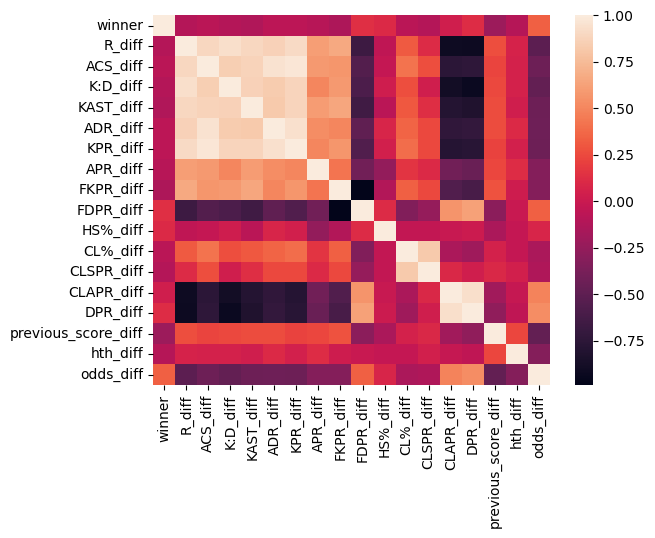

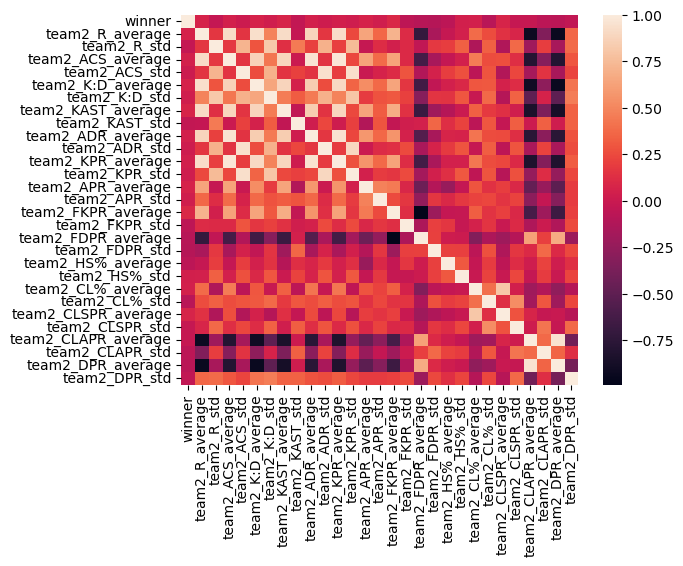

In [19]:
# display a heatmap of the correlation between the columns
corr = matches_difference.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

# heatmap for averages
# remove all T1 because they are the same as T2 but with a negative correlation
matches_average_t2 = matches_average[[col for col in matches_average.columns if "team1" not in col]]
corr = matches_average_t2.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

THe kill related stats seem to have a lot of correlation with each other. This makes sense because if a team gets more kills all of those stats go up. Same thing for the previous game stats. If a team wins their last couple games their kills are more likely higher.

## Get the accuracy of odds

Uses the team with the lower payout in the betting odds to predict the winner

In [20]:
# Picks predicted winner based on the highest odds
def manually_score(odds_diff_label: str, row: pd.Series) -> int:
  # if columns have "odds_diff"
  if "odds_diff" in row:
    return float(row[odds_diff_label] > 0) + 1
  
  return float(row["t1 odds"] > row["t2 odds"]) + 1

# Gets the accuracy the odds for a given dataset
def score_from_odds(data: pd.DataFrame, odds_diff_label: str = "odds_diff") -> float:
  predictions = data.apply(partial(manually_score, odds_diff_label), axis=1)
  return (predictions == data["winner"]).sum() / len(data)


# print the accuracy of the model
print("Accuracy of odds: ", score_from_odds(matches_average))


Accuracy of odds:  0.6194444444444445


## Splitting data

When either splitting categorical data I keep the distribution of the data the same in the training and testing sets

For continuous data I put then in ordered bins so the sets will generally have the same distribution throughout

In [21]:
# Split the input dataset into training and testing datasets.
def split_data(df: pd.DataFrame, target_column: str, test_size: float = 0.2, bins: int = 10, continuous: bool = False, seed=None) -> tuple[pd.DataFrame, pd.DataFrame]:
  if continuous:
    # Split evenly into bins with equal amount of data
    binned = pd.cut(df[target_column], bins, labels = False)
    
    # Splits the data based on the bins
    train_data, test_data = train_test_split(df, test_size = test_size, stratify = binned, random_state=seed)
    
    return train_data, test_data
  
  else:
    # Divides up equally between the target classes
    train, test = pd.DataFrame(), pd.DataFrame()
    
    # For each target
    for target in df[target_column].unique():
      # Gets only the data with the target value
      target_data = df[df[target_column] == target]
      
      # splits into train and test
      train_data = target_data.sample(frac = 1 - test_size, random_state=seed)
      test_data = target_data.drop(train_data.index)
      
      # Concats to the train and test dataframes
      train = pd.concat([train, train_data])
      test = pd.concat([test, test_data])
    
    return train, test

## Accuracy tester functions

This is a wrapper function for the classifier that allows for streamlined testing with easy ways to change different aspects like making it seeded, use KNN, or measure the time it takes to run. There is also an average function that allows for easy testing of the classifier over multiple runs.

In [22]:
# Runs the classifier with the given criterion can return float, a tuple of 2 floats, or None
def classifier_wrapper(classifier, data_set: pd.DataFrame, target_column: str, feature_columns: List[str], seed: Optional[int] = None, test_size: float = 0.2, 
                      cross_fold: bool = False, n_splits: int = 5, track_time: bool = False, do_confusion_matrix: bool = False,
                      display_confusion_matrix: bool = False, skip_testing: bool = False, **kwargs) -> Union[float, Tuple[float, float, float], None]:
  
  if (seed is not None):
    random.seed(seed)
  
  # Initializes the decision tree classifier
  try:
    clf = classifier(random_state=random.randint(0, 10000000), **kwargs)
  except TypeError:
    clf = classifier(**kwargs)

  
  if cross_fold:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random.randint(0, 10000000))
    scores = cross_val_score(clf, data_set[feature_columns], data_set[target_column], cv=cv)
    return float(scores.mean())
  
  # Splits the data into training and testing data
  train, test = split_data(data_set, target_column, test_size=test_size, seed=random.randint(0, 10000000))
  
  if track_time:
    start = time()
  # Fits the clf to the training data
  clf.fit(train[feature_columns], train[target_column])
    
  if track_time:
    train_time = time() - start
  
  # If skip_testing is True, then the classifier is not trained
  if skip_testing:
    return None
  
  if track_time:
    start = time()
    
  # Predicts the target values for the test data
  predictions = clf.predict(test[feature_columns])
  
  if track_time:
    track_time = time() - start
  
  # Calculates the accuracy of the classifier
  #accuracy = float(accuracy_score(test[target_column], predictions))
  accuracy = float(clf.score(test[feature_columns], test[target_column]))
  
  if display_confusion_matrix:
    # display heatmap of confusion matrix
    confusion_matrix = pd.crosstab(test[target_column], predictions, rownames=["Actual"], colnames=["Predicted"])
    sns.heatmap(confusion_matrix, annot=True)
  
  if do_confusion_matrix:
    # creates a confusion matrix
    confusion_matrix = pd.crosstab(test[target_column], predictions, rownames=["Actual"], colnames=["Predicted"])
    if track_time:
      return accuracy, train_time, track_time, confusion_matrix
    else:
      return accuracy, confusion_matrix
  
  if track_time:
    return accuracy, train_time, track_time
  
  return accuracy


# Gets the average accuracy of the decision tree classifier over x iterations
def average_accuracy(*args, iterations=100, seed: Optional[int] = None, cross_fold: bool = True, **kwargs) -> Union[float, Tuple[float, float, float], None]:
  accuracy = 0
  averageTimeTrain = 0
  averageTimeTest = 0
  confusion_matrix = None
  
  if seed is not None:
    random.seed(seed)
    
    
  if (kwargs.get("display_confusion_matrix", False)):
    kwargs["do_confusion_matrix"] = True
    kwargs["display_confusion_matrix"] = False
  
  for _ in range(iterations):
    return_val = classifier_wrapper(*args, cross_fold=cross_fold, **kwargs)
    
    if type(return_val) is float:
      accuracy += return_val
    elif type(return_val) is tuple:
      accuracy += return_val[0]
      if (len(return_val) >= 3):
        averageTimeTrain += return_val[1]
        averageTimeTest += return_val[2]
        if (len(return_val) == 4):
          conf_matrix = return_val[3]
      else:
          conf_matrix = return_val[1]
          
      if confusion_matrix is None:
        confusion_matrix = conf_matrix
      else:
        confusion_matrix += conf_matrix
  
  if confusion_matrix is not None:
    # display heatmap of confusion matrix
    confusion_matrix /= float(iterations)
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
  
  # Returns the average accuracy if accuracy was calculated
  if averageTimeTrain != 0:
    return accuracy / iterations, averageTimeTrain / iterations, averageTimeTest / iterations
  if accuracy != 0:
    return accuracy / iterations
  return None

## Hyperparameter tester functions

These functions allow for easy testing of different hyperparameters for the classifier. It lets you pass in one or two hyperparameters tagged with _range with a range of different values to test. With one hyperparameter it will test all the values in the range and with two it will test all the combinations of the two hyperparameters and display a matrix.

In [23]:
# Graphs the accuracy and training time with the given range of values
# only one _range variable can be passed in the kwargs
def graph_hyperparameters(*args, log_graph: bool = False, seed: Optional[int] = None, cross_fold: bool = True, graph_time: bool = False, **kwargs) -> None:
  
  # if one or no _range variables are passed, then return
  if len([name for name in kwargs if name.endswith("_range")]) != 1:
    return
  
  if seed is None:
    seed = random.randint(0, 100000)   
  
  # extract the _range variable from the kwargs 
  name, val_range = [(name, value) for name, value in kwargs.items() if name.endswith("_range")][0]
  value_range = val_range.copy()
  
  args = list(args)
  if name == "features_range" and len(args) == 3:
    args.append("temp")
    
    
  # Makes a copy of the kwargs and removes the name_range variable
  newKwargs = kwargs.copy()
  newKwargs.pop(name)
  
  newKwargs.pop("square_root_iterations", None)
  
  # Gets the variable name without the _range
  variable_name = name[:-6]
  accuracies = []
  train_times = []
  test_times = []
  
  # For each value in the range
  for value in value_range:
    if variable_name == "features":
      args[3] = value
    else:
      newKwargs[variable_name] = value
    
    if graph_time:
      # Gets the average training and test time
      accuracy, train_time, test_time = average_accuracy(*args, track_time=True, cross_fold=cross_fold, seed=seed, **newKwargs)
      
      accuracies.append(accuracy)
      train_times.append(train_time)
      test_times.append(test_time)
    else:
      # Accuracy is calculated with cross validation
      accuracy = average_accuracy(*args, track_time=False, cross_fold=cross_fold, seed=seed, **newKwargs)
      
      accuracies.append(accuracy)
  
  if graph_time:
    # Print the most accurate value
    print(f"Most accurate {variable_name}: {value_range[np.argmax(accuracies)]} with accuracy: {max(accuracies)} and train time: {train_times[np.argmax(accuracies)]}, test time: {test_times[np.argmax(accuracies)]}")
  else:
    # Print the most accurate value
    print(f"Most accurate {variable_name}: {value_range[np.argmax(accuracies)]} with accuracy: {max(accuracies)}")
  
  
  # Graphs the accuracies and training times
  
  if type(value_range[0]) is list:
    for i in range(len(value_range)):
      value_range[i] = len(value_range[i])
      
  
  # Plots the accuracies
  plt.plot(value_range, accuracies, label="Accuracy")
  plt.xlabel(variable_name)
  plt.ylabel("Accuracy")
  plt.title(f"Accuracy vs {variable_name}")
  if log_graph:
    plt.xscale("log", base=2) # Makes scale a base 2 log scale
  plt.show()
  
  if not graph_time:
    return 
  
  # Plots the training times
  plt.plot(value_range, train_times, label="Time")
  plt.xlabel(variable_name)
  plt.ylabel("Time")
  plt.title(f"Train Time vs {variable_name}")
  if log_graph:
    plt.xscale("log", base=2) # Makes scale a base 2 log scale
  plt.show()
  
  # Plots the test times
  plt.plot(value_range, test_times, label="Time")
  plt.xlabel(variable_name)
  plt.ylabel("Time")
  plt.title(f"Test Time vs {variable_name}")
  if log_graph:
    plt.xscale("log", base=2)
  
# Creates a heatmap of the accuracy of the classifier with two _range variables
def heatmap_hyperparameters(*args, seed: Optional[int] = None, cross_fold: bool = True, graph_time: bool = False, square_root_iterations: bool = False, **kwargs) -> None:
  # if two _range variables are passed, then return
  if len([name for name in kwargs if name.endswith("_range")]) != 2:
    return
  
  if square_root_iterations and "iterations" in kwargs:
    iterations = kwargs["iterations"]
    kwargs["iterations"] = int(np.sqrt(iterations))
      
  if seed is None:
    seed = random.randint(0, 100000)   
  
  ranges = [(name, value) for name, value in kwargs.items() if name.endswith("_range")]
    
  # extract the _range variable from the kwargs 
  name, val_range = ranges[0]
  value_range = val_range.copy()
  
  # extract the _range variable from the kwargs 
  name2, val_range2 = ranges[1]
  value_range2 = val_range2.copy()
  
  args = list(args)
  if name == "features_range" and len(args) == 3:
    args.append("temp")
    
  # Makes a copy of the kwargs and removes the name_range variable
  newKwargs = kwargs.copy()
  newKwargs.pop(name)
  newKwargs.pop(name2)
  
  # Gets the variable name without the _range
  variable_name = name[:-6]
  variable_name2 = name2[:-6]
  
  accuracies = np.zeros((len(value_range) + 1, len(value_range2) + 1))
  train_times = np.zeros((len(value_range) + 1, len(value_range2) + 1))
  test_times = np.zeros((len(value_range) + 1, len(value_range2) + 1))
  
  for i, value in enumerate(value_range):
    for j, value2 in enumerate(value_range2):
      newKwargs[variable_name] = value
      newKwargs[variable_name2] = value2
      if graph_time:
        # Gets the average training and test time
        accuracies[i + 1][j + 1], train_times[i + 1][j + 1], test_times[i + 1][j + 1] = average_accuracy(*args, track_time=True, cross_fold=cross_fold, seed=seed, **newKwargs)
      else:
        # Accuracy is calculated with cross validation
        accuracy = average_accuracy(*args, track_time=False, cross_fold=cross_fold, seed=seed, **newKwargs)

        accuracies[i + 1][j + 1] = accuracy
        
  # add default values
  for i, value in enumerate(value_range):
    newKwargs[variable_name] = value
    newKwargs.pop(variable_name2, None)
    if graph_time:
      accuracies[i + 1][0], train_times[i + 1][0], test_times[i + 1][0] = average_accuracy(*args, track_time=True, cross_fold=cross_fold, seed=seed, **newKwargs)
    else:
      accuracies[i + 1][0] = average_accuracy(*args, track_time=False, cross_fold=cross_fold, seed=seed, **newKwargs)
  
  for j, value in enumerate(value_range2):
    newKwargs[variable_name2] = value
    newKwargs.pop(variable_name, None)
    if graph_time:
      accuracies[0][j + 1], train_times[0][j + 1], test_times[0][j + 1] = average_accuracy(*args, track_time=True, cross_fold=cross_fold, seed=seed, **newKwargs)
    else:
      accuracies[0][j + 1] = average_accuracy(*args, track_time=False, cross_fold=cross_fold, seed=seed, **newKwargs)
  
  newKwargs.pop(variable_name, None)
  newKwargs.pop(variable_name2, None)
  if graph_time:
    accuracies[0][0], train_times[0][0], test_times[0][0] = average_accuracy(*args, track_time=True, cross_fold=cross_fold, seed=seed, **newKwargs)
  else:
    accuracies[0][0] = average_accuracy(*args, track_time=False, cross_fold=cross_fold, seed=seed, **newKwargs)
    
  
  xticks = ["Default"] + [str(value) for value in value_range2]
  yticks = ["Default"] + [str(value) for value in value_range]    
  
  # Print the most accurate value
  max_index = np.argmax(accuracies)
  max_index = np.unravel_index(max_index, accuracies.shape)
  
  print(f"Most accurate {variable_name}: {yticks[max_index[0]]} and {variable_name2}: {xticks[max_index[1]]} with accuracy: {accuracies[max_index]}")
  

  
  # Graphs the heatmap
  sns.heatmap(accuracies, annot=True, xticklabels=xticks, yticklabels=yticks, cmap="RdYlGn")
  plt.xlabel(variable_name2)
  plt.ylabel(variable_name)
  plt.title(f"Accuracy vs {variable_name} and {variable_name2}")
  plt.show()
  
  if not graph_time:
    return 
  
  # Graphs the heatmap of the training times
  sns.heatmap(train_times, annot=True, xticklabels=xticks, yticklabels=yticks, cmap="summer")
  plt.xlabel(variable_name2)
  plt.ylabel(variable_name)
  plt.title(f"Train Time vs {variable_name} and {variable_name2}")
  plt.show()
  
  # Graphs the heatmap of the test times
  sns.heatmap(test_times, annot=True, xticklabels=xticks, yticklabels=yticks, cmap="summer")
  plt.xlabel(variable_name2)
  plt.ylabel(variable_name)
  plt.title(f"Test Time vs {variable_name} and {variable_name2}")
  plt.show()
  
  
# Picks from graph_hyperparameters or heatmap_hyperparameters based on the number of _range variables
def test_hyperparameters(*args, **kwargs) -> None:
  
  if len([name for name in kwargs if name.endswith("_range")]) == 1:
    graph_hyperparameters(*args, **kwargs)
  elif len([name for name in kwargs if name.endswith("_range")]) == 2:
    heatmap_hyperparameters(*args, **kwargs)

# Testing different datasets

In [29]:
seed = 0

## Base datasets

In [30]:
print("Accuracy from Difference:", average_accuracy(RandomForestClassifier, matches_difference, "winner", difference_features, iterations=10, seed=seed+1))
print("Accuracy from Average:", average_accuracy(RandomForestClassifier, matches_average, "winner", average_features, iterations=10, seed=seed+1))
print("Accuracy from Players:", average_accuracy(RandomForestClassifier, matches_players, "winner", players_features, iterations=10, seed=seed+1))

Accuracy from Difference: 0.5944444444444443
Accuracy from Average: 0.606111111111111
Accuracy from Players: 0.5369444444444446


The datasets performed well with the average and deviation merge performing the best. The difference merge was close behind. Using the raw stats from the players by far performed the worst.

### Combining difference and average datasets

Because both performed well I want to see if combining the two will perform better than either alone.

In [31]:
# merge average and difference
matches_average_difference = pd.concat([matches_average, matches_difference], axis=1)
# drop duplicate columns
matches_average_difference = matches_average_difference.loc[:,~matches_average_difference.columns.duplicated()]
display(matches_average_difference.head(5))

# merge lists and remove duplicates
average_difference_features = list(dict.fromkeys(average_features + difference_features))
print(average_difference_features)

,winner,t1 odds,t2 odds,team1_previous_score,team2_previous_score,team1_hth,team2_hth,team1_R_average,team1_R_std,team1_ACS_average,...,FKPR_diff,FDPR_diff,HS%_diff,CL%_diff,CLSPR_diff,CLAPR_diff,DPR_diff,previous_score_diff,hth_diff,odds_diff
0,1,1.85,1.85,4,5,0.0,0.0,0.986,0.105972,201.60,...,0.016,-0.012,-9.6,-1.4,0.002273,0.020455,0.053977,-1,0.0,0.00
1,2,2.4,1.5,4,5,0.0,0.0,1.080,0.038079,204.86,...,0.016,-0.016,2.8,8.6,0.002491,0.005812,-0.024957,-1,0.0,0.90
2,2,5.0,1.13,3,3,0.0,0.0,0.902,0.171959,197.00,...,0.030,-0.034,3.2,7.8,0.015007,0.031602,0.096537,0,0.0,3.87
3,2,1.88,1.82,3,2,0.0,0.0,1.040,0.180693,205.38,...,0.030,-0.032,-4.2,-8.8,-0.012115,-0.019856,-0.029231,1,0.0,0.06
4,1,1.68,2.05,3,4,4.966667,5.666667,1.076,0.187563,207.24,...,-0.010,0.016,-2.0,-13.2,-0.014077,-0.030244,-0.070801,-1,-0.7,-0.37


['team1_previous_score', 'team2_previous_score', 'team1_hth', 'team2_hth', 'team1_R_average', 'team1_R_std', 'team1_ACS_average', 'team1_ACS_std', 'team1_K:D_average', 'team1_K:D_std', 'team1_KAST_average', 'team1_KAST_std', 'team1_ADR_average', 'team1_ADR_std', 'team1_KPR_average', 'team1_KPR_std', 'team1_APR_average', 'team1_APR_std', 'team1_FKPR_average', 'team1_FKPR_std', 'team1_FDPR_average', 'team1_FDPR_std', 'team1_HS%_average', 'team1_HS%_std', 'team1_CL%_average', 'team1_CL%_std', 'team1_CLSPR_average', 'team1_CLSPR_std', 'team1_CLAPR_average', 'team1_CLAPR_std', 'team1_DPR_average', 'team1_DPR_std', 'team2_R_average', 'team2_R_std', 'team2_ACS_average', 'team2_ACS_std', 'team2_K:D_average', 'team2_K:D_std', 'team2_KAST_average', 'team2_KAST_std', 'team2_ADR_average', 'team2_ADR_std', 'team2_KPR_average', 'team2_KPR_std', 'team2_APR_average', 'team2_APR_std', 'team2_FKPR_average', 'team2_FKPR_std', 'team2_FDPR_average', 'team2_FDPR_std', 'team2_HS%_average', 'team2_HS%_std', '

Testing the accuracy with the difference match stats 

In [32]:
print("Accuracy from Difference:", average_accuracy(RandomForestClassifier, matches_difference, "winner", difference_features, iterations=10, seed=seed+1))
print("Accuracy from Average:", average_accuracy(RandomForestClassifier, matches_average, "winner", average_features, iterations=10, seed=seed+1))
print("Accuracy from Difference + Average:", average_accuracy(RandomForestClassifier, matches_average_difference, "winner", average_difference_features, iterations=10, seed=seed+1))

Accuracy from Difference: 0.5944444444444443
Accuracy from Average: 0.606111111111111
Accuracy from Difference + Average: 0.6175


It performed much better together than alone

## Testing average without deviation

In [33]:
# Get features but drop _std
features_no_std = [col for col in average_difference_features if "_std" not in col]
print("Accuracy with no deviation:", average_accuracy(RandomForestClassifier, matches_average_difference, "winner", features_no_std, iterations=10, seed=seed+1))

Accuracy with no deviation: 0.6030555555555555


Removing the deviation seemed to have a small hit to the performance.

## Adding difference match stats to average

When testing I found a huge increase in the performance of difference when adding the head to head and previous games but it wasn't that much of an improvement for average so I am adding the difference versions to the average set

In [34]:
new_average_data = pd.concat([matches_average, matches_difference[["odds_diff", "previous_score_diff", "hth_diff"]]], axis=1)
new_average_features = average_features + ["previous_score_diff", "hth_diff"]

print("Accuracy from average with diffs:", average_accuracy(RandomForestClassifier, new_average_data, "winner", new_average_features, iterations=10, seed=seed+1))

Accuracy from average with diffs: 0.6199999999999999


Surprising it performed better with only these stats from the difference transferred over. This could be because with all of the stats the models would overfit more.

## Difference with deviation

In [ ]:

deviations = [col for col in matches_average.columns if "_std" in col]
new_diff_data = pd.concat([matches_difference, matches_average[deviations]], axis=1)
new_diff_features = difference_features + deviations

print("Accuracy of Difference:", average_accuracy(RandomForestClassifier, matches_difference, "winner", difference_features, iterations=10, seed=seed+1))
print("Accuracy from diffs with deviation:", average_accuracy(RandomForestClassifier, new_diff_data, "winner", new_diff_features, iterations=10, seed=seed+1))

Accuracy of Difference: 0.5944444444444443
Accuracy from diffs with deviation: 0.6138888888888888


It definitely improved it's accuracy over the normal difference. It even managed to be the second best dataset overall

## Setting dataset to test

Because average with the difference for head to head and previous scores performed the best I will use this dataset for the rest of the testing. But to not all of the following testing for winner classification was done for the average dataset with and without previous games/hth, difference dataset with and without previous games/hth, and all of average and difference.

Notably as the dataset got better and better the amount of pruning needed decreased and the amount of estimators it benefited from increased.

In [ ]:
matches_data = new_average_data
feature_columns = new_average_features

In [ ]:
# export matches_data
matches_data.to_csv("cleaned_dataset.csv", index=False)

# Testing hyperparameters

## Decision Tree

In [ ]:
# bind matches_averaged, "winner", feature_columns to graph_training_samples
decision_tree_tester = partial(test_hyperparameters, DecisionTreeClassifier, matches_data, "winner", feature_columns, iterations = 25, square_root_iterations=True, seed=seed)

Most accurate max_depth: 8 and min_samples_split: 8 with accuracy: 0.5955555555555554


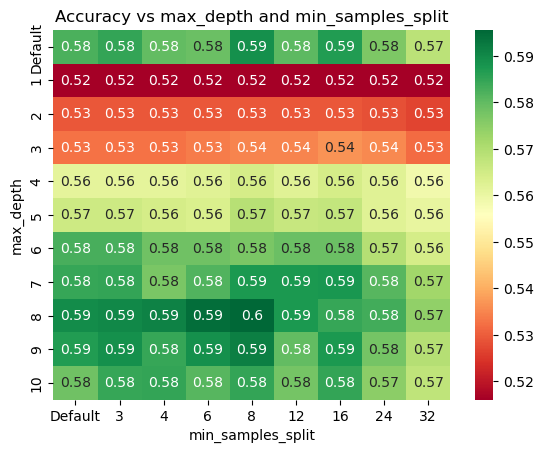

In [ ]:
decision_tree_tester(max_depth_range=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], min_samples_split_range=[3, 4, 6, 8, 12, 16, 24, 32])

Most accurate ccp_alpha: 0.0 with accuracy: 0.5831111111111114


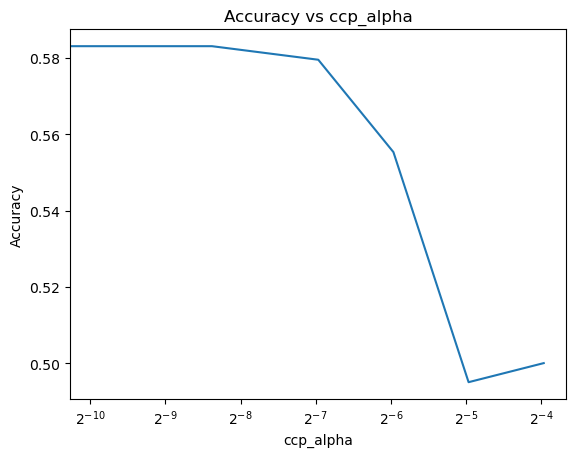

In [ ]:
decision_tree_tester(ccp_alpha_range=[0.0, 0.001, 0.003, 0.008, 0.016, 0.032, 0.064], log_graph = True)

In [ ]:
# for some reason if no pruning is set the result of the ada boost is the same no matter the 
decision_tree_class = partial(DecisionTreeClassifier, max_depth=8)
decision_tree_classifier = decision_tree_class()

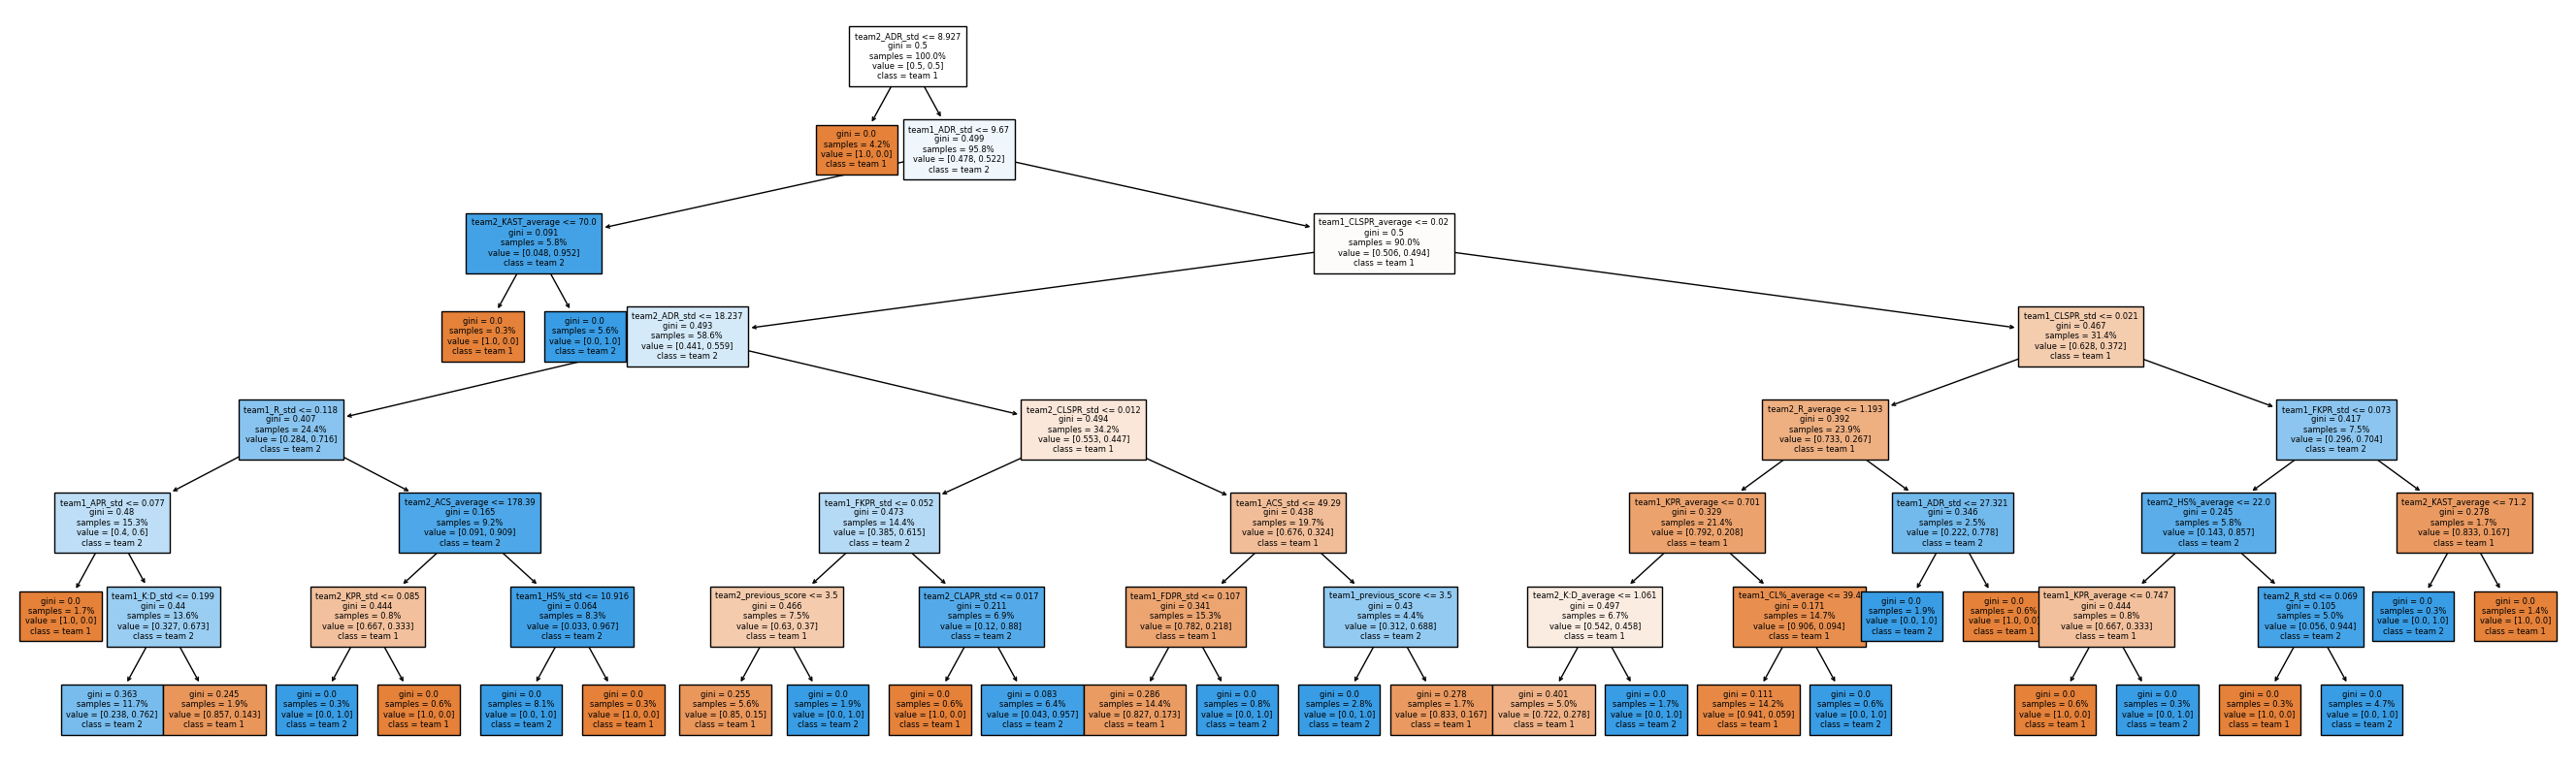

In [ ]:
# temp tree for displaying the tree (less depth)
temp_tree = DecisionTreeClassifier(max_depth=7)
temp_tree.fit(matches_data[feature_columns], matches_data["winner"])
plt.figure(figsize=(34, 10))
plot_tree(temp_tree, filled=True, feature_names=feature_columns, class_names=["team 1", "team 2"], fontsize=6, proportion=True)
plt.show()

- Performs surprisingly well but the accuracy varies a lot between tests
- The tree comes to logical conclusions with the given data
- Like how teams with high kill related ratings are more likely to win against teams with a lot of deviation
- The default hyperparameters worked great but because of a quirk with AdaBoost I set the max depth to 8


## AdaBoost Tree

In [ ]:
ada_boost_tree = partial(AdaBoostClassifier, decision_tree_classifier)

ada_boost_tester = partial(test_hyperparameters, ada_boost_tree, matches_data, "winner", feature_columns, iterations=5, square_root_iterations=True, seed=seed+1)

Most accurate n_estimators: 250 with accuracy: 0.6011111111111112


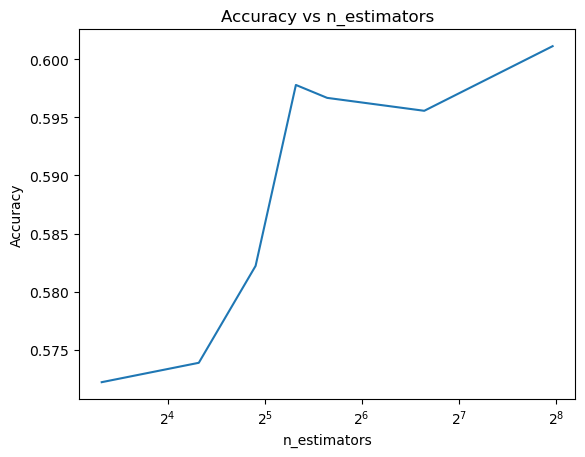

In [ ]:
# ~40 being the best seems like an outlier but it is consistent with different seeds
ada_boost_tester(n_estimators_range=[10, 20, 30, 40, 50, 100, 250], iterations=5, log_graph=True)

Most accurate learning_rate: 1.0 with accuracy: 0.5966666666666666


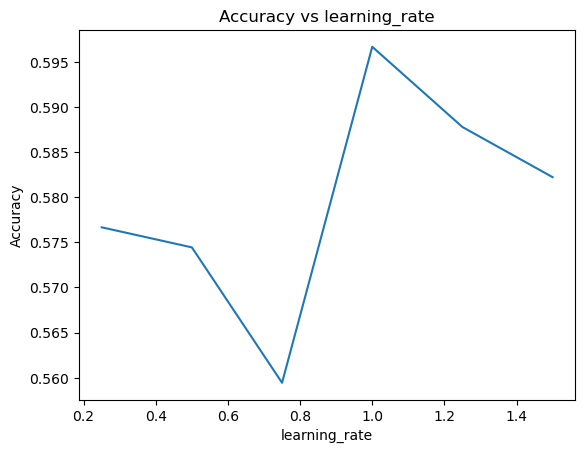

In [ ]:
# Even with different seeds 
ada_boost_tester(learning_rate_range=[0.25, 0.5, 0.75, 1.0, 1.25, 1.5])

In [ ]:
print("Accuracy: ", average_accuracy(ada_boost_tree, matches_data, "winner", feature_columns, n_estimators=250, display_confusion_matrix=True, iterations=5, seed=seed+1))

Accuracy:  0.6011111111111112


In [ ]:
ada_boost_class = partial(ada_boost_tree, n_estimators=250)
ada_boost_classifier = ada_boost_class()

- Improved performance from the decision tree
- Decision tree from last slide was used as a base
- Hyperparameters were tricky to find
- The results from both n_estimators and learning_rate varied a lot between seeds
- I ended with 250 estimators performing the best


## Random Forest

In [ ]:
# bind matches_averaged, "winner", feature_columns to graph_training_samples
random_forest_tester = partial(test_hyperparameters, RandomForestClassifier, matches_data, "winner", feature_columns, iterations=5, seed=seed+1)

Most accurate max_depth: 7 with accuracy: 0.6227777777777778


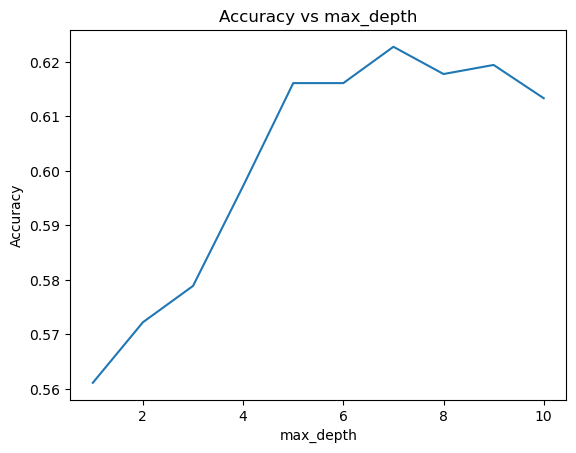

In [ ]:
random_forest_tester(max_depth_range=[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None])

Most accurate ccp_alpha: 0.004 with accuracy: 0.6188888888888889


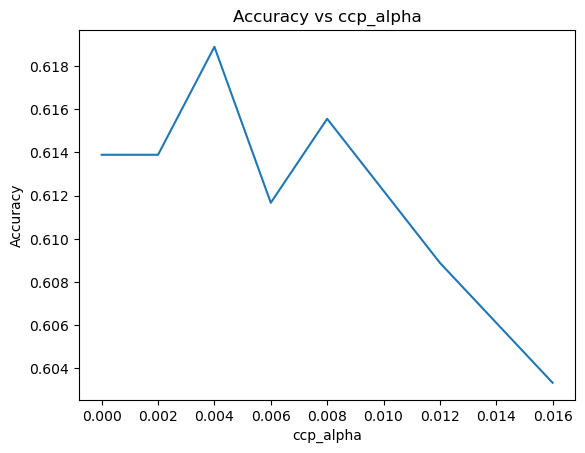

In [ ]:
# Default seed is an outlier
random_forest_tester(ccp_alpha_range=[0, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016])

Most accurate min_samples_split: 4 with accuracy: 0.6266666666666667


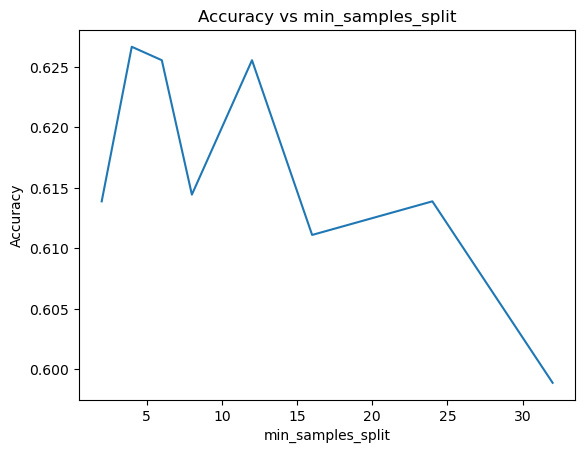

In [ ]:
# base seed is an outlier
random_forest_tester(min_samples_split_range=[2, 4, 6, 8, 12, 16, 24, 32])

Most accurate min_samples_leaf: 2 with accuracy: 0.6205555555555555


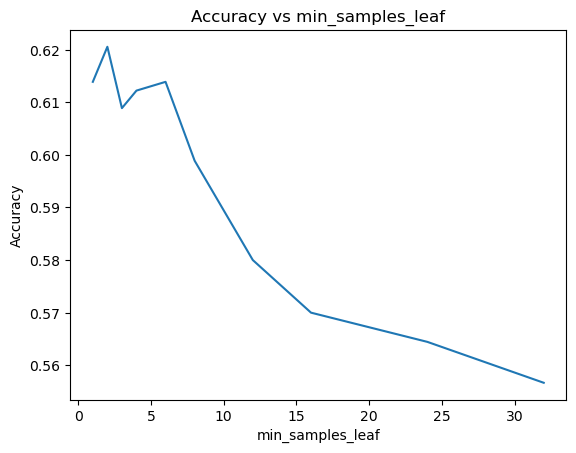

In [ ]:
random_forest_tester(min_samples_leaf_range=[1, 2, 3, 4, 6, 8, 12, 16, 24, 32])

Accuracy with whole:  0.6261111111111111
Most accurate max_samples: None with accuracy: 0.6138888888888889


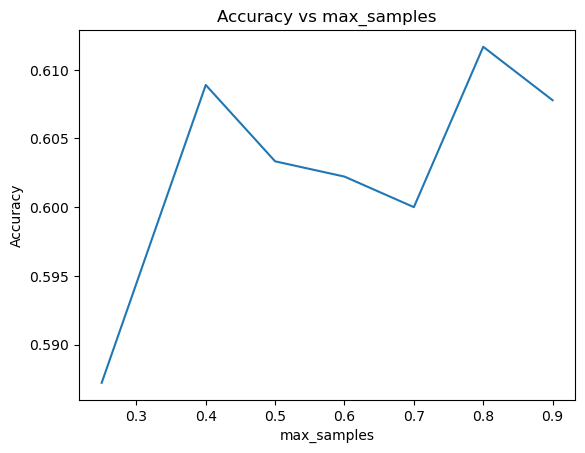

In [ ]:
# for whatever reason entering 1 breaks it and makes the accuracy 50/50 so I am printing it
print("Accuracy with whole: ", average_accuracy(RandomForestClassifier, matches_data, "winner", feature_columns, max_samples=None, iterations=5))
random_forest_tester(max_samples_range=[0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, None])

Most accurate n_estimators: 50 with accuracy: 0.5966666666666667


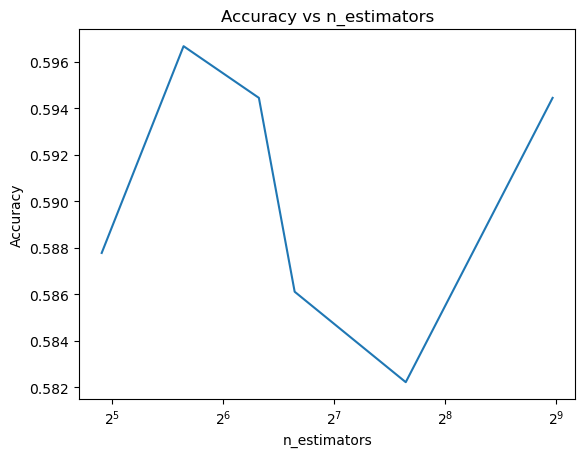

Most accurate n_estimators: 500 with accuracy: 0.6027777777777777


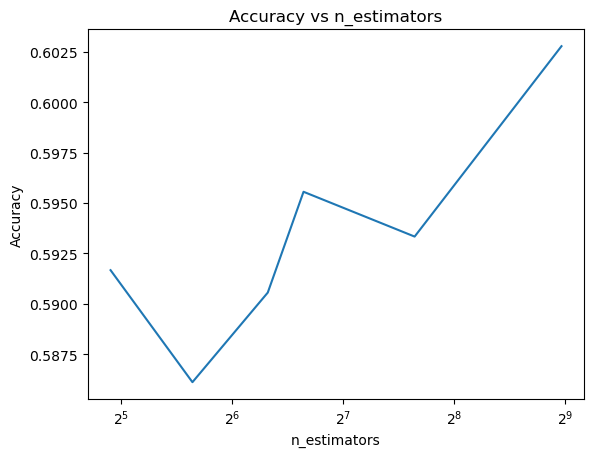

In [ ]:
# base seed is an outlier
random_forest_tester(n_estimators_range=[30, 50, 80, 100, 200, 500], max_samples=0.9, log_graph=True, seed=seed+3) 
# Without max_samples
random_forest_tester(n_estimators_range=[30, 50, 80, 100, 200, 500], log_graph=True, seed=seed+3) 

In [ ]:
random_forest_class = partial(RandomForestClassifier, max_depth=7, n_estimators=500)
random_forest_classifier = random_forest_class()

- Most pruning methods performed well
- Like the other models this model varied a lot between seeds
- The accuracy seeming improved with the amount of estimators so I ended up picking 500

# Final model test

In [ ]:
# testing with a different seed
print("Accuracy from Odds:", score_from_odds(matches_data))

print("Accuracy from DecisionTree:", average_accuracy(decision_tree_class, matches_data, "winner", feature_columns, iterations=100, seed=seed+1))

print("Accuracy from AdaBoost:", average_accuracy(ada_boost_class, matches_data, "winner", feature_columns, iterations=5, seed=seed+1))

print("Accuracy from RandomForest:", average_accuracy(random_forest_class, matches_data, "winner", feature_columns, iterations=10, seed=seed+1))

Accuracy from Odds: 0.6194444444444445
Accuracy from DecisionTree: 0.5748888888888888
Accuracy from AdaBoost: 0.6011111111111112
Accuracy from RandomForest: 0.6213888888888889


The accuracy of the Random Forest beat out the accuracy of the odds. Given that the betting odds are most likely made by a team of people, have much more data go into it, and probably more advanced models I am very happy with the results.

# Predicting the odds of a match

In [35]:
# Using the average dataset with diffs for match stats
regress_data = new_average_data
display(regress_data.head(5))

# exclude odds and winner
regress_features = [col for col in regress_data.columns if col != "winner" and col != "odds_diff" and col != "t1 odds" and col != "t2 odds"]

,winner,t1 odds,t2 odds,team1_previous_score,team2_previous_score,team1_hth,team2_hth,team1_R_average,team1_R_std,team1_ACS_average,...,team2_CL%_std,team2_CLSPR_average,team2_CLSPR_std,team2_CLAPR_average,team2_CLAPR_std,team2_DPR_average,team2_DPR_std,odds_diff,previous_score_diff,hth_diff
0,1,1.85,1.85,4,5,0.0,0.0,0.986,0.105972,201.60,...,32.797866,0.022727,0.032141,0.104545,0.076399,0.677273,0.040656,0.00,-1,0.0
1,2,2.4,1.5,4,5,0.0,0.0,1.080,0.038079,204.86,...,13.809417,0.019048,0.026082,0.111111,0.068272,0.711111,0.058752,0.90,-1,0.0
2,2,5.0,1.13,3,3,0.0,0.0,0.902,0.171959,197.00,...,7.602631,0.003175,0.007099,0.104762,0.058966,0.676190,0.079840,3.87,0,0.0
3,2,1.88,1.82,3,2,0.0,0.0,1.040,0.180693,205.38,...,14.258331,0.024615,0.017541,0.129231,0.031902,0.729231,0.042967,0.06,1,0.0
4,1,1.68,2.05,3,4,4.966667,5.666667,1.076,0.187563,207.24,...,16.272676,0.017886,0.012059,0.123577,0.067631,0.720325,0.035717,-0.37,-1,-0.7


In [ ]:
# predict the odds of the match
accuracy = average_accuracy(RandomForestRegressor, regress_data, "odds_diff", regress_features, seed=seed, iterations=10, cross_fold=False)

print("Accuracy from model:", accuracy)

Accuracy from model: 0.5552832998178177


In [ ]:
random_forest_regressor_tester = partial(test_hyperparameters, RandomForestRegressor, regress_data, "odds_diff", regress_features, iterations=5, square_root_iterations=True, cross_fold=False, seed=seed)

Most accurate max_depth: Default and min_samples_split: 3 with accuracy: 0.4948868667798194


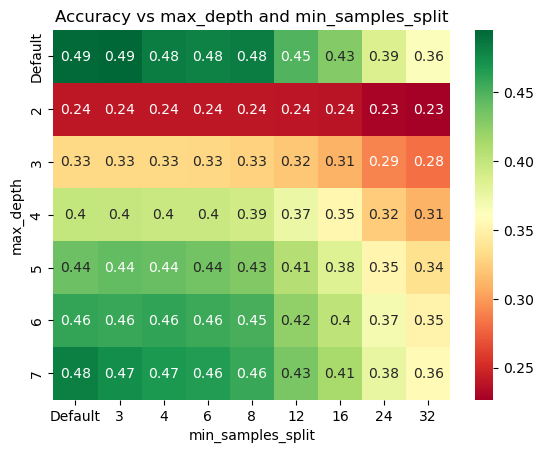

In [ ]:
random_forest_regressor_tester(max_depth_range=[2, 3, 4, 5, 6, 7], min_samples_split_range=[3, 4, 6, 8, 12, 16, 24, 32], seed=seed+1)

Most accurate ccp_alpha: 0 with accuracy: 0.5776918018322335


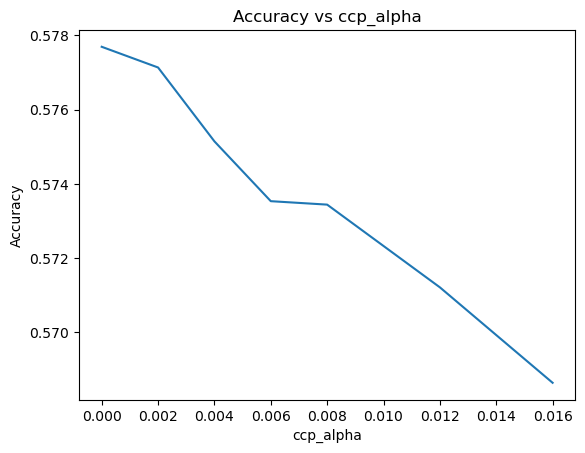

In [ ]:
random_forest_regressor_tester(ccp_alpha_range=[0, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016], iterations=5)

Most accurate n_estimators: 1000 with accuracy: 0.5852263054315555


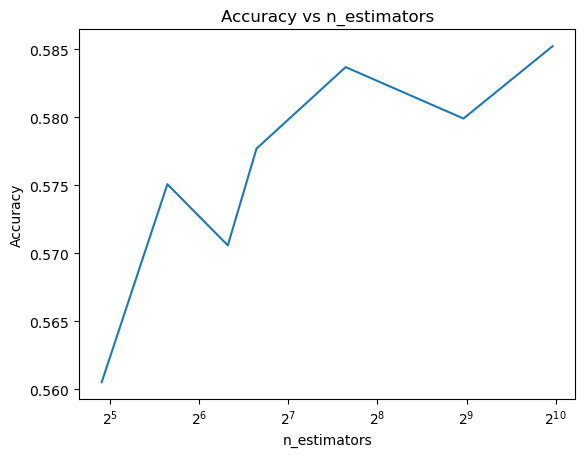

In [ ]:
# First seeds are outliers
random_forest_regressor_tester(n_estimators_range=[30, 50, 80, 100, 200, 500, 1000], log_graph=True)

The accuracy of the model consistently went up with the amount of estimators in the model.

#### Testing the accuracy

In [ ]:
average_accuracy(RandomForestRegressor, regress_data, "odds_diff", regress_features, n_estimators=1000, iterations=10, cross_fold=False, seed=seed)

0.5617559217337565

## Graphing the odds prediction

In [36]:
random.seed(0)
# Split data
regress_train, regress_test = split_data(regress_data, "odds_diff", continuous=True, seed=random.randint(0, 1000000))

# Train classifier
random_forest_regressor_clf = RandomForestRegressor(n_estimators=1000, random_state=random.randint(0, 1000000))
random_forest_regressor_clf.fit(regress_train[regress_features], regress_train["odds_diff"])

# Predict the odds
predictions = random_forest_regressor_clf.predict(regress_test[regress_features])

### Functions for graphing the predictions of the classifier

In [37]:
# Gets the slope of the trendline
def get_slope(base: pd.Series, predicted: pd.Series) -> float:
  slope, _, _, _, _ = linregress(base, predicted)
  return slope

# Create a scatter plot of the predicted values vs the actual values with a diagonal line
def scatter_plot(test_data: pd.DataFrame, predictions: pd.Series, target_column: str, title: str, fit_trendline: bool = False) -> None:
  if fit_trendline:
    # Getting a multiplier for the trendline so the slopes meet
    slope = get_slope(regress_test["odds_diff"], random_forest_regressor_clf.predict(regress_test[regress_features]))
    # Scale to match the trendline
    predictions = predictions * (1/slope)
  
  # Highest value for the bounds
  highest_value = max(test_data[target_column].max(), predictions.max(), abs(test_data[target_column].min()), abs(predictions.min())) + 1
  
  
  # tint the 1st quadrant blue, 3rd quadrant green with imshow
  # first quadrant
  plt.imshow([[0, 0]], cmap="coolwarm", alpha=0.3, extent=[-highest_value, highest_value, 0, highest_value])
  
  plt.imshow([[0, 0]], cmap="summer", alpha=0.3, extent=[-highest_value, highest_value, -highest_value, 0])
  
  
  # dotted lines for 0
  plt.axhline(0, color="grey", linestyle="--", label='_nolegend_')
  plt.axvline(0, color="grey", linestyle="--", label='_nolegend_')
  
  # plots the scatter plot green for team 1 and blue for team 2
  plt.scatter(test_data[target_column], predictions, c=test_data["winner"].apply(lambda x: "green" if x == 1 else "blue"), label='_nolegend_')
  
  # for the legend
  plt.scatter([], [], color="green", label="Team 1")
  plt.scatter([], [], color="blue", label="Team 2")
  
  # plots the diagonal line with a label Expected
  plt.plot([-highest_value, highest_value], [-highest_value, highest_value], color="green", label="Expected")
  
  # trendline
  plt.plot(np.unique(test_data[target_column]), np.poly1d(np.polyfit(test_data[target_column], predictions, 1))(np.unique(test_data[target_column])), color="red", label="Trendline")
  
  # Add legend for the 2 lines
  plt.legend(["Team 1", "Team 2", "Expected", "Trendline"])
  
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title(title)
  
  plt.show()

### Graphing the predictions

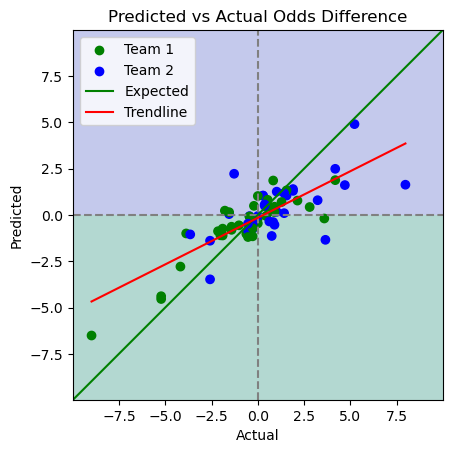

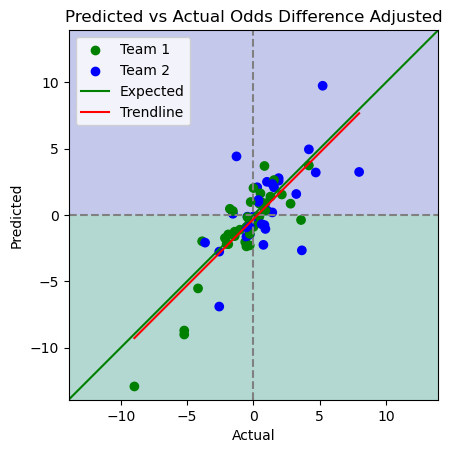

In [38]:
scatter_plot(regress_test, predictions, "odds_diff", "Predicted vs Actual Odds Difference")
scatter_plot(regress_test, predictions, "odds_diff", "Predicted vs Actual Odds Difference Adjusted", fit_trendline=True)

The prediction consistently underestimated the result so I tweak I did was adjust the slopes to have the prediction match the trendline. Even though the odds predicted the wrong winner our prediction still matched the trendline.

### Converting predicted odds_diff into odds

It still needs to have a cut taken from it

In [ ]:
# add the predicted odds to the matches_data
prediction_data = regress_test[["winner", "odds_diff", "t1 odds", "t2 odds"]].copy(deep=True)
prediction_data["predicted_odds_diff"] = random_forest_regressor_clf.predict(regress_test[regress_features])

# scale the predicted odds to match the trendline
slope = get_slope(regress_test["odds_diff"], prediction_data["predicted_odds_diff"])
prediction_data["predicted_odds_diff"] = prediction_data["predicted_odds_diff"] * (1/slope)
display(prediction_data.head(5))


def get_odds(row_name: str, row: pd.Series) -> tuple[float, float]:
  # if odds_diff > 0 then the eq is t1odds - 1/t1odds = -1
  # else the eq is 1/t1odds - t1odds = -1
  # and t2 odds is 1/t1odds
  diff = abs(row[row_name])
  if row[row_name] > 0:
    t1_odds = (diff + np.sqrt(diff ** 2 + 4)) / 2
    t2_odds = 1 / t1_odds
  else:
    t2_odds = (diff + np.sqrt(diff ** 2 + 4)) / 2
    t1_odds = 1 / t2_odds
  return t1_odds + 1, t2_odds + 1

prediction_data["predicted t1 odds"], prediction_data["predicted t2 odds"] = zip(*prediction_data.apply(partial(get_odds, "predicted_odds_diff"), axis=1))
prediction_data["calculated t1 odds"], prediction_data["calculated t2 odds"] = zip(*prediction_data.apply(partial(get_odds, "odds_diff"), axis=1))

# set the predicted winner
prediction_data["predicted winner"] =  (prediction_data["predicted_odds_diff"] > 0) + 1
display(prediction_data.head(10))

,winner,odds_diff,t1 odds,t2 odds,predicted_odds_diff
191,1,0.53,2.15,1.62,1.002065
23,2,-1.55,1.35,2.9,0.088839
278,1,-1.90,1.3,3.2,-2.205945
39,1,-0.28,1.72,2.0,-0.558683
20,1,2.14,3.4,1.26,1.539272


,winner,odds_diff,t1 odds,t2 odds,predicted_odds_diff,predicted t1 odds,predicted t2 odds,calculated t1 odds,calculated t2 odds,predicted winner
191,1,0.53,2.15,1.62,1.002065,2.619528,1.617464,2.299517,1.769517,2
23,2,-1.55,1.35,2.9,0.088839,2.045406,1.956566,1.490158,3.040158,2
278,1,-1.90,1.3,3.2,-2.205945,1.385835,3.591780,1.429311,3.329311,1
39,1,-0.28,1.72,2.0,-0.558683,1.758942,2.317624,1.869752,2.149752,1
20,1,2.14,3.4,1.26,1.539272,3.031516,1.492243,3.534548,1.394548,2
306,1,0.00,1.85,1.85,-0.905160,1.645067,2.550227,2.000000,2.000000,1
60,1,2.80,4.0,1.2,0.846556,2.509171,1.662615,4.120465,1.320465,2
206,2,3.65,4.8,1.15,-2.671636,1.332837,4.004473,4.906015,1.256015,1
136,2,0.28,2.0,1.72,2.053754,3.460221,1.406467,2.149752,1.869752,2
111,1,0.00,1.85,1.85,-0.387699,1.824766,2.212465,2.000000,2.000000,1


The calculated is what tit should be and the predicted is the prediction. The bot seems to predict it with many of the predictions being extremely close to the expected result.

#### Getting the accuracy from the predicted odds

In [ ]:
score_from_odds(prediction_data, "predicted_odds_diff")

0.5694444444444444

The odds of the prediction vary a lot between seeds but it usually falls anywhere from 52%-58%. but the actual odds it is predicting seems to be close

# Predicting matches in ongoing tournament

## Loading the dataset

This dataset is of an ongoing tournament

In [ ]:
# Load test set from "final_test_set.csv"
test_set_average = get_dataset(MergeType.AVERAGE, "final_test_set.csv", True, False)
test_set_difference = get_dataset(MergeType.DIFFERENCE, "final_test_set.csv", True, False)

# Adding the odds_diff, previous_score_diff, and hth_diff to the test set
new_test = pd.concat([test_set_average, test_set_difference[["odds_diff", "previous_score_diff", "hth_diff"]]], axis=1)

In [ ]:
display(new_test.head())

,date,team1,team2,winner,team1_previous_score,team2_previous_score,team1_hth,team2_hth,t1 odds,t2 odds,...,team2_CL%_std,team2_CLSPR_average,team2_CLSPR_std,team2_CLAPR_average,team2_CLAPR_std,team2_DPR_average,team2_DPR_std,odds_diff,previous_score_diff,hth_diff
0,"April 13, 2024",G2 Esports,100 Thieves,2,3,0,0.000000,0.0,0.0,0.0,...,6.260990,0.004762,0.010648,0.128571,0.086831,0.742857,0.039123,0.0,3,0.000000
1,"April 13, 2024",Sentinels,Leviatán,2,4,2,10.400000,6.0,0.0,0.0,...,29.168476,0.008108,0.012087,0.100000,0.082532,0.664865,0.047201,0.0,2,4.400000
2,"April 14, 2024",NRG Esports,FURIA,1,3,0,23.066667,0.0,0.0,0.0,...,10.848963,0.021875,0.017815,0.131250,0.064989,0.753125,0.052291,0.0,3,23.066667
3,"April 15, 2024",Cloud9,Evil Geniuses,1,2,3,0.000000,2.2,0.0,0.0,...,10.954451,0.010811,0.014803,0.151351,0.024174,0.832432,0.044410,0.0,-1,-2.200000
4,"April 20, 2024",Sentinels,MIBR,2,3,3,20.400000,0.0,0.0,0.0,...,11.180340,0.005000,0.011180,0.130000,0.054199,0.750000,0.084779,0.0,0,20.400000


### Train on full dataset and predicting test set

In [ ]:
# Setting up the classifier
random.seed(seed)
classifier = random_forest_class(random_state=random.randint(0, 10000))

# Shuffle data and fit
shuffled = matches_data.sample(frac=1, random_state=random.randint(0, 10000))
classifier.fit(shuffled[feature_columns], shuffled["winner"])

# Test the classifier on the test set
test_set_predictions = classifier.predict(new_test[feature_columns])

### Making a dataframe with team names, predicted winner, and real winner

In [ ]:
# Create a table with the team names and then the prediction
test_predictions = pd.DataFrame(data={"team1": test_set_average["team1"], "team2": test_set_average["team2"], "predicted_winner": test_set_predictions, "winner": test_set_average["winner"]})

# change from number to team name
test_predictions["predicted_winner"] = test_predictions.apply(lambda row: row["team1"] if row["predicted_winner"] == 1 else row["team2"], axis=1)
test_predictions["winner"] = test_predictions.apply(lambda row: row["team1"] if row["winner"] == 1 else row["team2"], axis=1)

# Winners with index >= 4 are yet to play, replace winner with np.nan
test_predictions.loc[test_predictions.index >= 4, "winner"] = np.nan

### Adding odds before match for reference

In [ ]:
# [t1 odds, t2 odds]
odds = [[2.2, 1.58], [1.35, 2.9], [1.05, 7.5], [1.48, 2.5], [1.06, 7], 
        [2.70, 1.40], [np.nan, np.nan], [1.72, 2], [1.42, 2.7], [np.nan, np.nan],
        [np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan], [np.nan, np.nan]]

test_predictions["t1 odds"], test_predictions["t2 odds"] = zip(*odds)
test_predictions["odds prediction"] = test_predictions.apply(lambda row: row["team1"] if row["t1 odds"] < row["t2 odds"] else row["team2"], axis=1)


### Adding Pro analyst predictions

In [ ]:
# Pro predictions
predictions = ["Split", "Sentinels", "NRG Esports", "Evil Geniuses", "Sentinels", 
               "LOUD", "KRÜ Esports", "NRG Esports", np.nan, np.nan,
               np.nan, np.nan, np.nan, "LOUD"]

test_predictions["pro prediction"] = predictions

In [ ]:
display(test_predictions)

,team1,team2,predicted_winner,winner,t1 odds,t2 odds,odds prediction,pro prediction
0,G2 Esports,100 Thieves,100 Thieves,100 Thieves,2.20,1.58,100 Thieves,Split
1,Sentinels,Leviatán,Sentinels,Leviatán,1.35,2.90,Sentinels,Sentinels
2,NRG Esports,FURIA,FURIA,NRG Esports,1.05,7.50,NRG Esports,NRG Esports
3,Cloud9,Evil Geniuses,Cloud9,Cloud9,1.48,2.50,Cloud9,Evil Geniuses
4,Sentinels,MIBR,MIBR,NaN,1.06,7.00,Sentinels,Sentinels
5,Cloud9,LOUD,LOUD,NaN,2.70,1.40,LOUD,LOUD
6,KRÜ Esports,Evil Geniuses,KRÜ Esports,NaN,NaN,NaN,Evil Geniuses,KRÜ Esports
7,NRG Esports,Leviatán,Leviatán,NaN,1.72,2.00,NRG Esports,NRG Esports
8,G2 Esports,FURIA,G2 Esports,NaN,1.42,2.70,G2 Esports,NaN
9,Cloud9,100 Thieves,Cloud9,NaN,NaN,NaN,100 Thieves,NaN


It weirdly seems to be good at predicting close matches but it is getting some of the easiest to predict matches wrong. Like it predicted FURIA when the odds were so bad the the payout of a win would be 6.5x.